In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import glob
import matplotlib as mpl
import netCDF4 as nc
from shapely.geometry import Polygon, LineString, Point
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os
import cartopy.feature as cfeature
import xarray as xr
import geopandas as gpd
import contextily as cx
import h5py

In [2]:
analysis_dataset_path = '/Users/zhu/Dropbox/Code/Publications/RACM2B-VCP-analysis-data/'
datapath = analysis_dataset_path+'surf_map/'
shapefile = gpd.read_file(analysis_dataset_path+"LA_Merge/LA_Merge.shp")

In [3]:
arrays = {}

filenames = ['vocr_daily_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t1_4km.mat',
            'vocr_daily_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t2_4km.mat',
            'vocr_daily_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t3_4km.mat']
vocr_combs = []
for filename in filenames:
    f = h5py.File(datapath + filename)
    for k, v in f.items():
        arrays[k] = np.array(v)
    this_vocr = arrays['vocr_comb']
    this_vocr = np.nansum(this_vocr[:,:,1:,:],axis=2)
    vocr_combs.append(this_vocr)
    xloncorn = arrays['xloncorn']
    xlatcorn = arrays['xlatcorn']
    lon = arrays['lon']
    lat = arrays['lat']

In [4]:
temp_bin = pd.read_csv(analysis_dataset_path+'temp_bin.csv')
indx = pd.to_datetime(temp_bin['date']).dt.month == 8
temp_bin = temp_bin.loc[indx,:].loc[:59,:]
temp_bin_index = temp_bin['temp_bin_index'].values

In [5]:
temp_bin['weekday'] = pd.to_datetime(temp_bin['date']).dt.weekday<5
weekday_indx = pd.to_datetime(temp_bin['date']).dt.weekday<5

In [6]:
weekday_indx.shape

(30,)

In [7]:
#evenly cut the 30 days into 3 temp bins
bins = pd.qcut(temp_bin['TEMP'],3,labels=False)
temp_bin_index = bins.values
#[(21.656, 27.027] < (27.027, 29.99] < (29.99, 34.434]]

In [8]:
lon = lon.flatten()
lat = lat.flatten()
area_indx = np.zeros(np.size(lon))
cls_indxs = []
for i in range(len(lon)):
    point = Point(lon[i], lat[i])
    classdefs = shapefile.loc[:,'geometry'].contains(point)
    if classdefs.any():
        area_indx[i] = 1
        
    classdefs_index = [k for k, x in enumerate(classdefs) if x]
    if len(classdefs_index) == 1:
        cls_indxs.append(classdefs_index[0])
    else:
        cls_indxs.append(5)
cls_indxs = np.array(cls_indxs)

In [9]:
fns = ['co','ch4','eth','hc3','hc5','hc8','ete','olt','oli','dien','ace','ben','tol','xyl','xyo','iso','api','lim',
       'hcho','acd','ald','act','mek','ket','hket','macr','mvk','uald','gly','mgly','dcb1','dcb2','dcb3','bald',
       'phen','csl','epx','mct','moh','eoh','roh','eteg','op1','op2','glyc','uhc','d4silx','d5silx','pcbtf','pdcbz',
       'nald','oald','cuald','cald','eclp']
clon1 = xloncorn[:,:,0]
clon2 = xloncorn[:,:,1]
clon3 = xloncorn[:,:,2]
clon4 = xloncorn[:,:,3]

clat1 = xlatcorn[:,:,0]
clat2 = xlatcorn[:,:,1]
clat3 = xlatcorn[:,:,2]
clat4 = xlatcorn[:,:,3]

In [17]:
vocr_combs[0].shape

(324, 264, 55, 31)

In [10]:
recap_days = list(range(1,31))

gdfs_tot = []
xlim =  [-118.6,-117.1]
ylim = [33.5,34.2] 
for i_day, this_day in enumerate(recap_days):
    gdfs = []
    for vocr_comb in vocr_combs:
        #o3 = np.nansum(vocr_comb[:,:,1:,i_day],2)
        o3 = vocr_comb[:,:,i_day]
        df_wrf = pd.DataFrame(data={'lon':lon.flatten(), 'lat':lat.flatten(),'o3':o3.flatten(),'cls_indxs':cls_indxs.flatten(),
                               'clon1':clon1.flatten(), 'clon2':clon2.flatten(),'clon3':clon3.flatten(),'clon4':clon4.flatten(),
                               'clat1':clat1.flatten(), 'clat2':clat2.flatten(),'clat3':clat3.flatten(),'clat4':clat4.flatten()})
        indx = (df_wrf['lon'] >= xlim[0]) & (df_wrf['lon'] <= xlim[1]) & (df_wrf['lat'] >= ylim[0]) & (df_wrf['lat'] <= ylim[1])
        #indx = area_indx == 1
        df_wrf = df_wrf.loc[indx,:]
        geometry_polygon = [Polygon([[df_wrf.loc[i,'clon1'], df_wrf.loc[i,'clat1']],
                [df_wrf.loc[i,'clon2'], df_wrf.loc[i,'clat2']],
                [df_wrf.loc[i,'clon3'], df_wrf.loc[i,'clat3']],
                [df_wrf.loc[i,'clon4'], df_wrf.loc[i,'clat4']]]) for i in df_wrf.index]
        gdf = gpd.GeoDataFrame(df_wrf, geometry=geometry_polygon)
        gdf.loc[:,'index'] = range(gdf.shape[0])
        #gdf = gdf.groupby(['clon1','clon2','clon3','clon4','clat1','clat2','clat3','clat4']).agg('mean').reset_index()
        gdf = gdf.set_crs('epsg:4326',allow_override=True)
        gdfs.append(gdf)

    gdfs_tot.append(gdfs)
    


Text(0, 0.5, 'Rel. contribution to VOC$_r$')

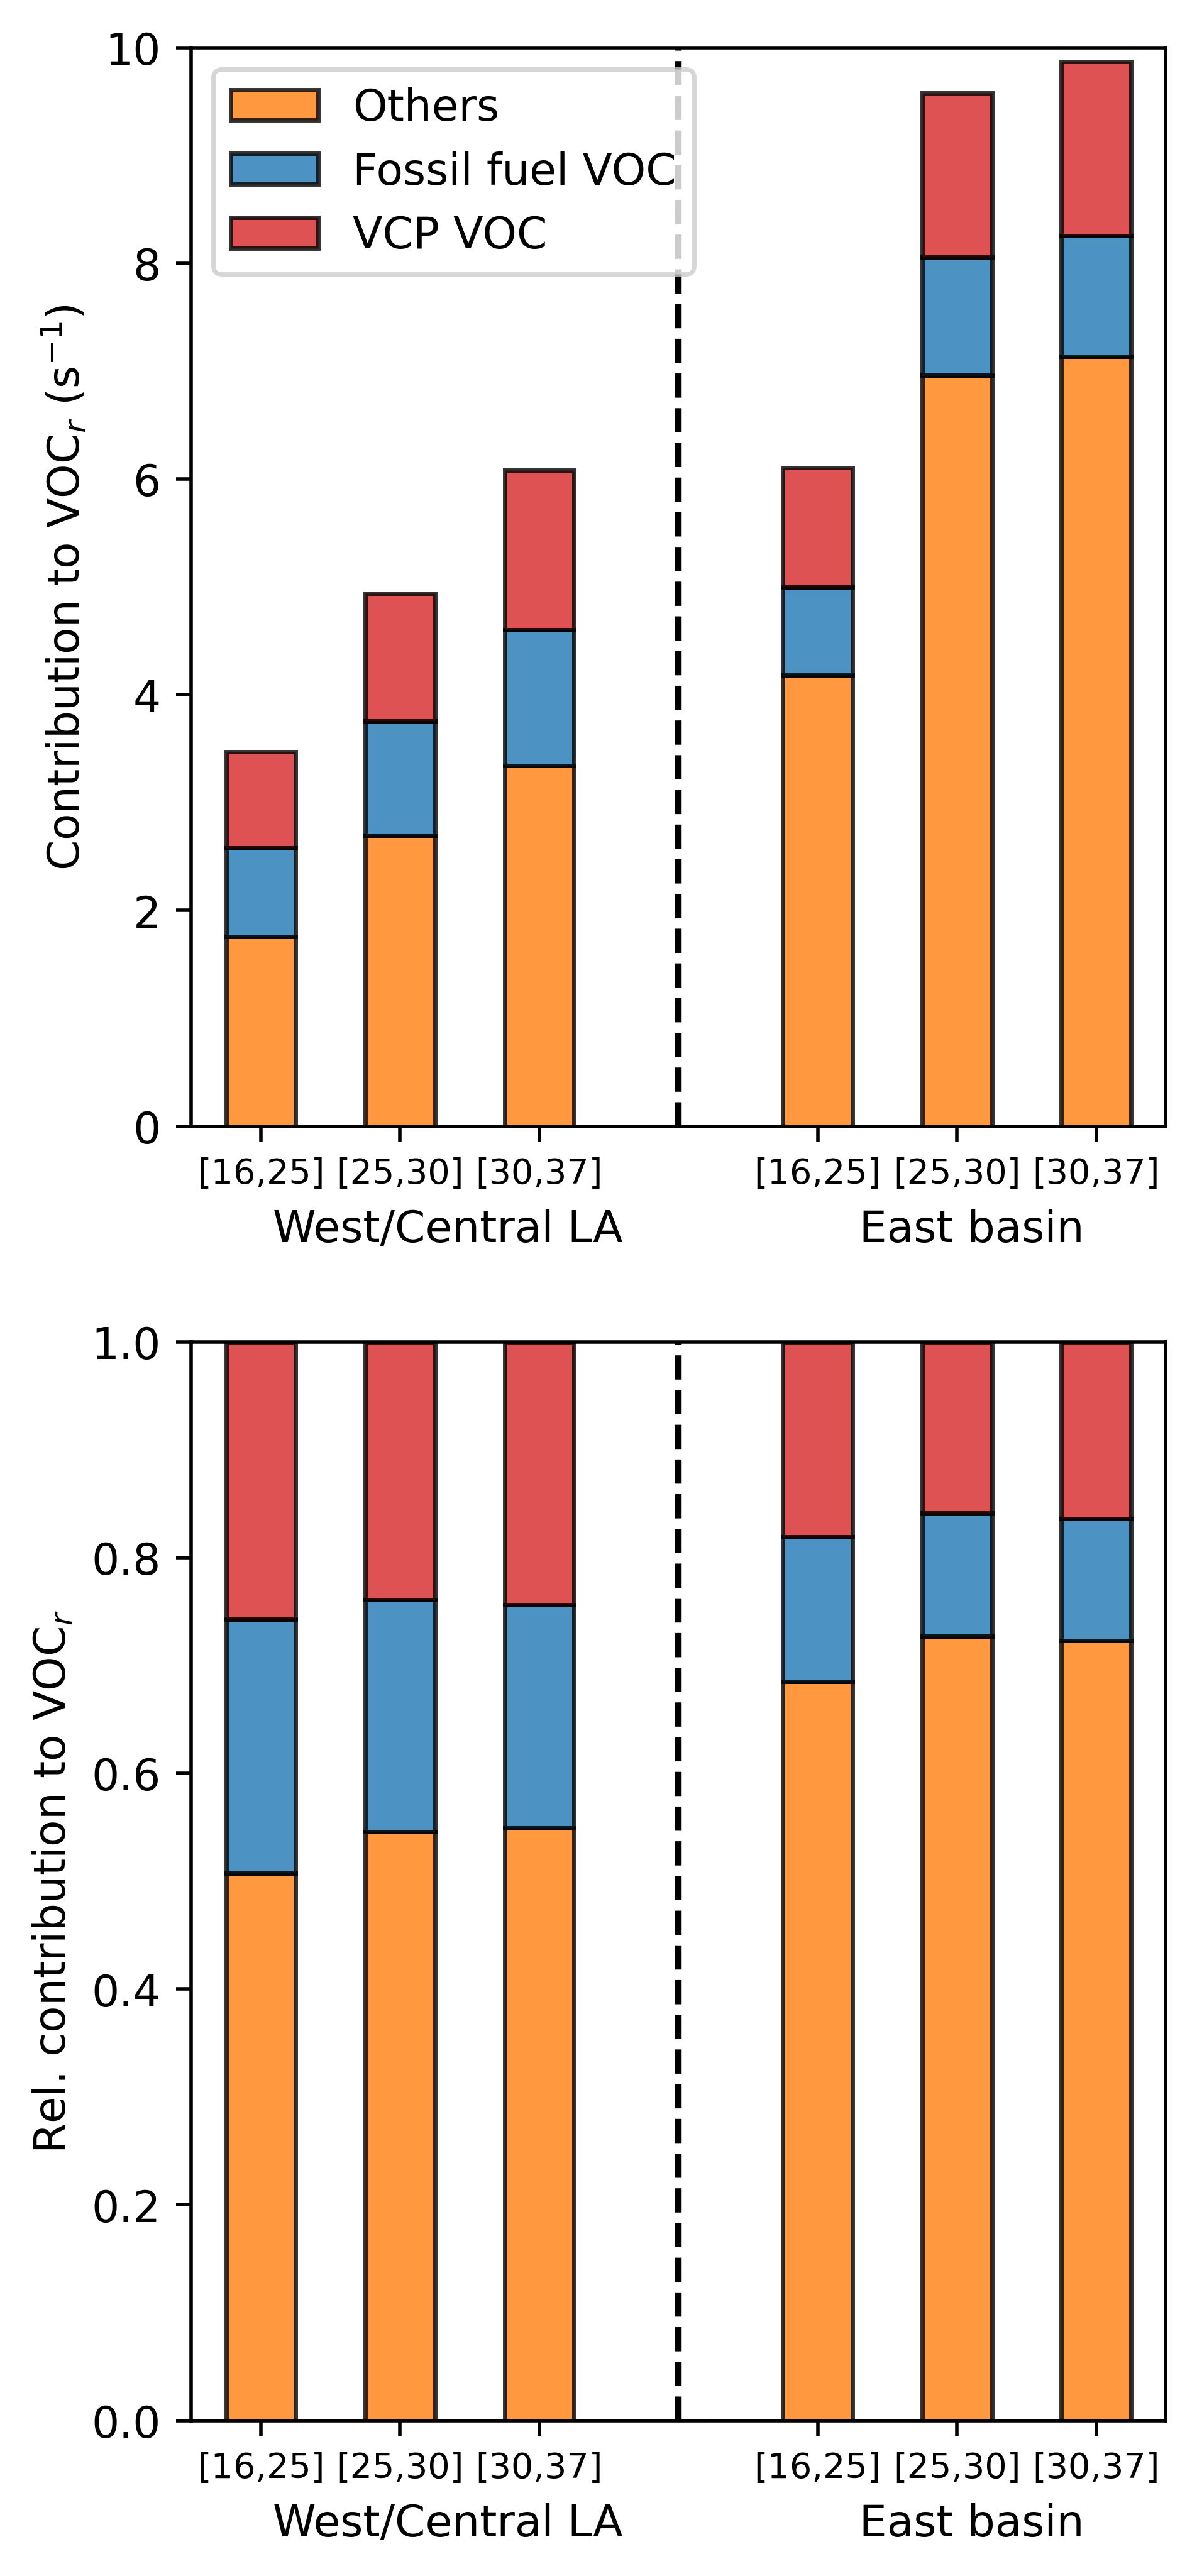

In [11]:
spc='o3'
o3_daily = pd.DataFrame()

for i_day, this_day in enumerate(recap_days):
    gdfs = gdfs_tot[i_day]
    west_indx = gdfs[1]['lon']<=-117.8
    o3_daily.loc[2*i_day,'VCP VOC'] = gdfs[1].loc[west_indx,spc].mean() - gdfs[2].loc[west_indx,spc].mean()
    o3_daily.loc[2*i_day,'Fossil fuel VOC'] = gdfs[2].loc[west_indx,spc].mean() - gdfs[0].loc[west_indx,spc] .mean()
    o3_daily.loc[2*i_day,'Others'] = gdfs[0].loc[west_indx,spc].mean()
    o3_daily.loc[2*i_day,'tot'] = gdfs[1].loc[west_indx,spc].mean()
    o3_daily.loc[2*i_day,'temp_bin_index'] = temp_bin_index[i_day]
    o3_daily.loc[2*i_day,'location'] = 'West/Central LA'

    east_indx = gdfs[1]['lon']>-117.8
    o3_daily.loc[2*i_day+1,'VCP VOC'] = gdfs[1].loc[east_indx,spc].mean() - gdfs[2].loc[east_indx,spc].mean()
    o3_daily.loc[2*i_day+1,'Fossil fuel VOC'] = gdfs[2].loc[east_indx,spc].mean() - gdfs[0].loc[east_indx,spc] .mean()
    o3_daily.loc[2*i_day+1,'Others'] = gdfs[0].loc[east_indx,spc].mean()
    o3_daily.loc[2*i_day+1,'tot'] = gdfs[1].loc[east_indx,spc].mean()
    o3_daily.loc[2*i_day+1,'temp_bin_index'] = temp_bin_index[i_day]+4
    o3_daily.loc[2*i_day+1,'location'] = 'East basin'
o3_daily.loc[60,'temp_bin_index']=3
o3_daily.loc[60,'location']='East basin'   
o3_daily_temp = o3_daily.groupby(['location','temp_bin_index']).mean()
o3_daily_temp['VCP VOC ratio'] = o3_daily_temp['VCP VOC']/o3_daily_temp['tot']
o3_daily_temp['Fossil fuel VOC ratio'] = o3_daily_temp['Fossil fuel VOC']/o3_daily_temp['tot']
o3_daily_temp['Others ratio'] = o3_daily_temp['Others']/o3_daily_temp['tot']
o3_daily_temp = o3_daily_temp.reset_index().set_index('temp_bin_index')
o3_daily_temp_ratio = o3_daily_temp.loc[:,['Others ratio','Fossil fuel VOC ratio','VCP VOC ratio','location']]

label = 'VOC$_r$'
fig, axs = plt.subplots(2,1,figsize=(4,10),dpi=500)
boxcolors = ['tab:orange','tab:blue','tab:red']
o3_daily_temp.loc[:,['Others','Fossil fuel VOC','VCP VOC']].sort_index().plot(kind='bar', stacked=True, ax=axs[0], color=boxcolors,edgecolor='black',alpha=0.8, rot=0,legend=True,label=['Background (30 ppb)','Others','Fossil fuel VOC','VCP VOC'])
#o3_daily_temp[o3_daily_temp['location']=='East basin'].loc[:,['background','others','fossil','VCP']].plot(kind='bar', stacked=True, ax=axs[0], edgecolor='black',alpha=0.8, rot=0)
axs[0].set_xticks([0,1,2,4,5,6],['[16,25]','[25,30]','[30,37]','[16,25]','[25,30]','[30,37]'], fontsize=8,rotation=0)
axs[0].plot([3,3],[0,10],color='k',linestyle='--')
axs[0].set_ylim([0,10])
axs[0].set_xlabel('West/Central LA                 East basin')
axs[0].set_ylabel('Contribution to VOC$_r$ (s$^{-1}$)')

o3_daily_temp_ratio.sort_index().plot(kind='bar', stacked=True, ax=axs[1], color=boxcolors,edgecolor='black',alpha=0.8, rot=0,legend=False)
#o3_daily_temp[o3_daily_temp['location']=='East basin'].loc[:,['background','others','fossil','VCP']].plot(kind='bar', stacked=True, ax=axs[0], edgecolor='black',alpha=0.8, rot=0)
axs[1].set_xticks([0,1,2,4,5,6],['[16,25]','[25,30]','[30,37]','[16,25]','[25,30]','[30,37]'], fontsize=8,rotation=0)
axs[1].plot([3,3],[0,1],color='k',linestyle='--')
axs[1].set_ylim([0,1])
axs[1].set_xlabel('West/Central LA                 East basin')
axs[1].set_ylabel('Rel. contribution to {}'.format(label))
#plt.text(-1.13, -0.1, 'West/Central LA', fontsize=10)
#plt.text(-0.53, -0.1, 'East basin', fontsize=10)


In [14]:
o3_daily_temp_ratio

,Others ratio,Fossil fuel VOC ratio,VCP VOC ratio,location
temp_bin_index,,,,
3.0,NaN,NaN,NaN,East basin
4.0,0.685232,0.133981,0.180787,East basin
5.0,0.727118,0.114162,0.158720,East basin
6.0,0.723205,0.112860,0.163935,East basin
0.0,0.507219,0.235331,0.257450,West/Central LA
1.0,0.545801,0.214909,0.239290,West/Central LA
2.0,0.549552,0.206879,0.243569,West/Central LA


In [15]:
0.133981-0.112860

0.021120999999999987

In [16]:
0.180787-0.163935

0.016852000000000006

In [17]:
o3_daily = pd.DataFrame()

for i_day, this_day in enumerate(recap_days):
    gdfs = gdfs_tot[i_day]
    o3_daily.loc[i_day,'VCP'] = gdfs[1]['o3'].mean() - gdfs[2]['o3'].mean()
    o3_daily.loc[i_day,'fossil'] = gdfs[2]['o3'].mean() - gdfs[0]['o3'].mean()
    o3_daily.loc[i_day,'others'] = gdfs[0]['o3'].mean()
    o3_daily.loc[i_day,'tot'] = gdfs[1]['o3'].mean()
    o3_daily.loc[i_day,'temp_bin_index'] = temp_bin_index[i_day]

In [18]:
o3_daily_temp = o3_daily.groupby('temp_bin_index').mean()
o3_daily_temp['VCP VOC'] = o3_daily_temp['VCP']/o3_daily_temp['tot']
o3_daily_temp['Fossil fuel VOC'] = o3_daily_temp['fossil']/o3_daily_temp['tot']
o3_daily_temp['Others'] = o3_daily_temp['others']/o3_daily_temp['tot']
o3_daily_temp_ratio = o3_daily_temp.loc[:,['Others','Fossil fuel VOC','VCP VOC']]

Text(0.5, 0, '')

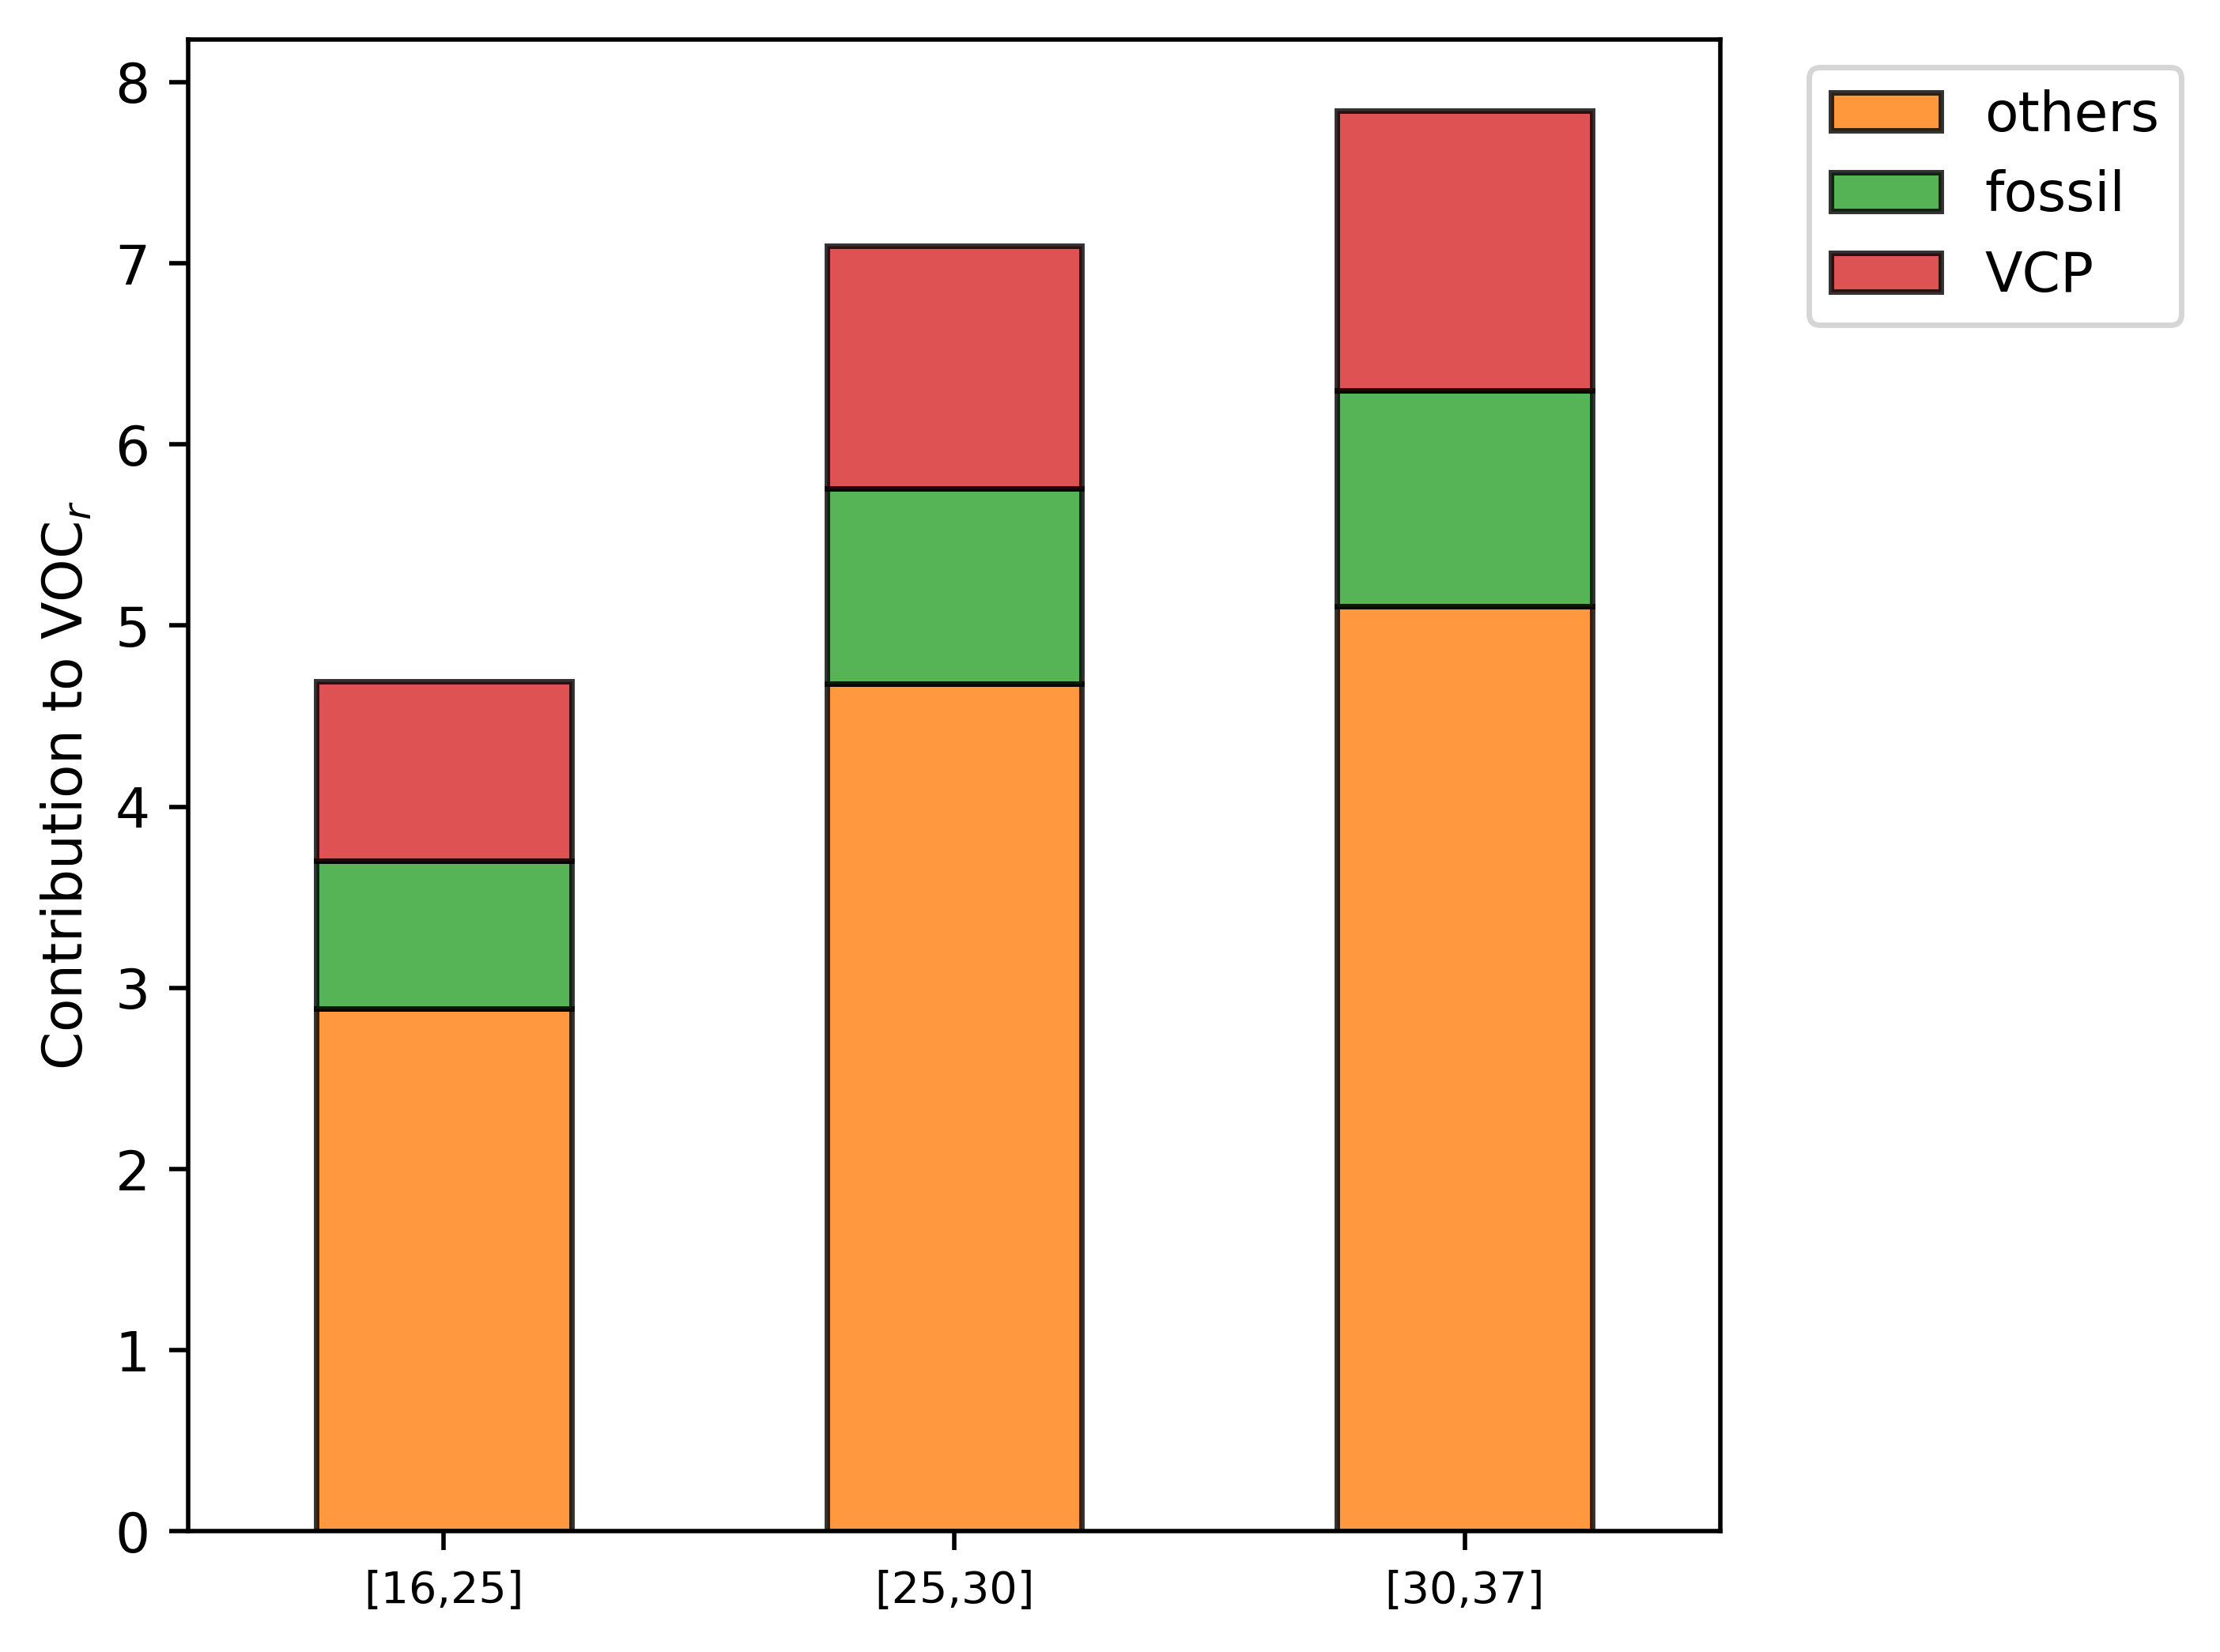

In [19]:
fig, axs = plt.subplots(1,1,figsize=(5,5),dpi=500)
boxcolors = ['tab:orange','tab:green','tab:red']
o3_daily_temp.loc[:,['others','fossil','VCP']].plot(kind='bar', stacked=True, ax=axs,color=boxcolors, edgecolor='black',alpha=0.8, rot=0)
axs.set_xticks(o3_daily_temp_ratio.index,['[16,25]','[25,30]','[30,37]'], fontsize=8,rotation=0)
#axs.set_xticks(o3_daily_temp_ratio.index,['[21,27]','[27,30]','[30,35]'], fontsize=8,rotation=0)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.ylim([0,1])
plt.ylabel('Contribution to VOC$_r$')
plt.xlabel('')

Text(0.5, 0, '')

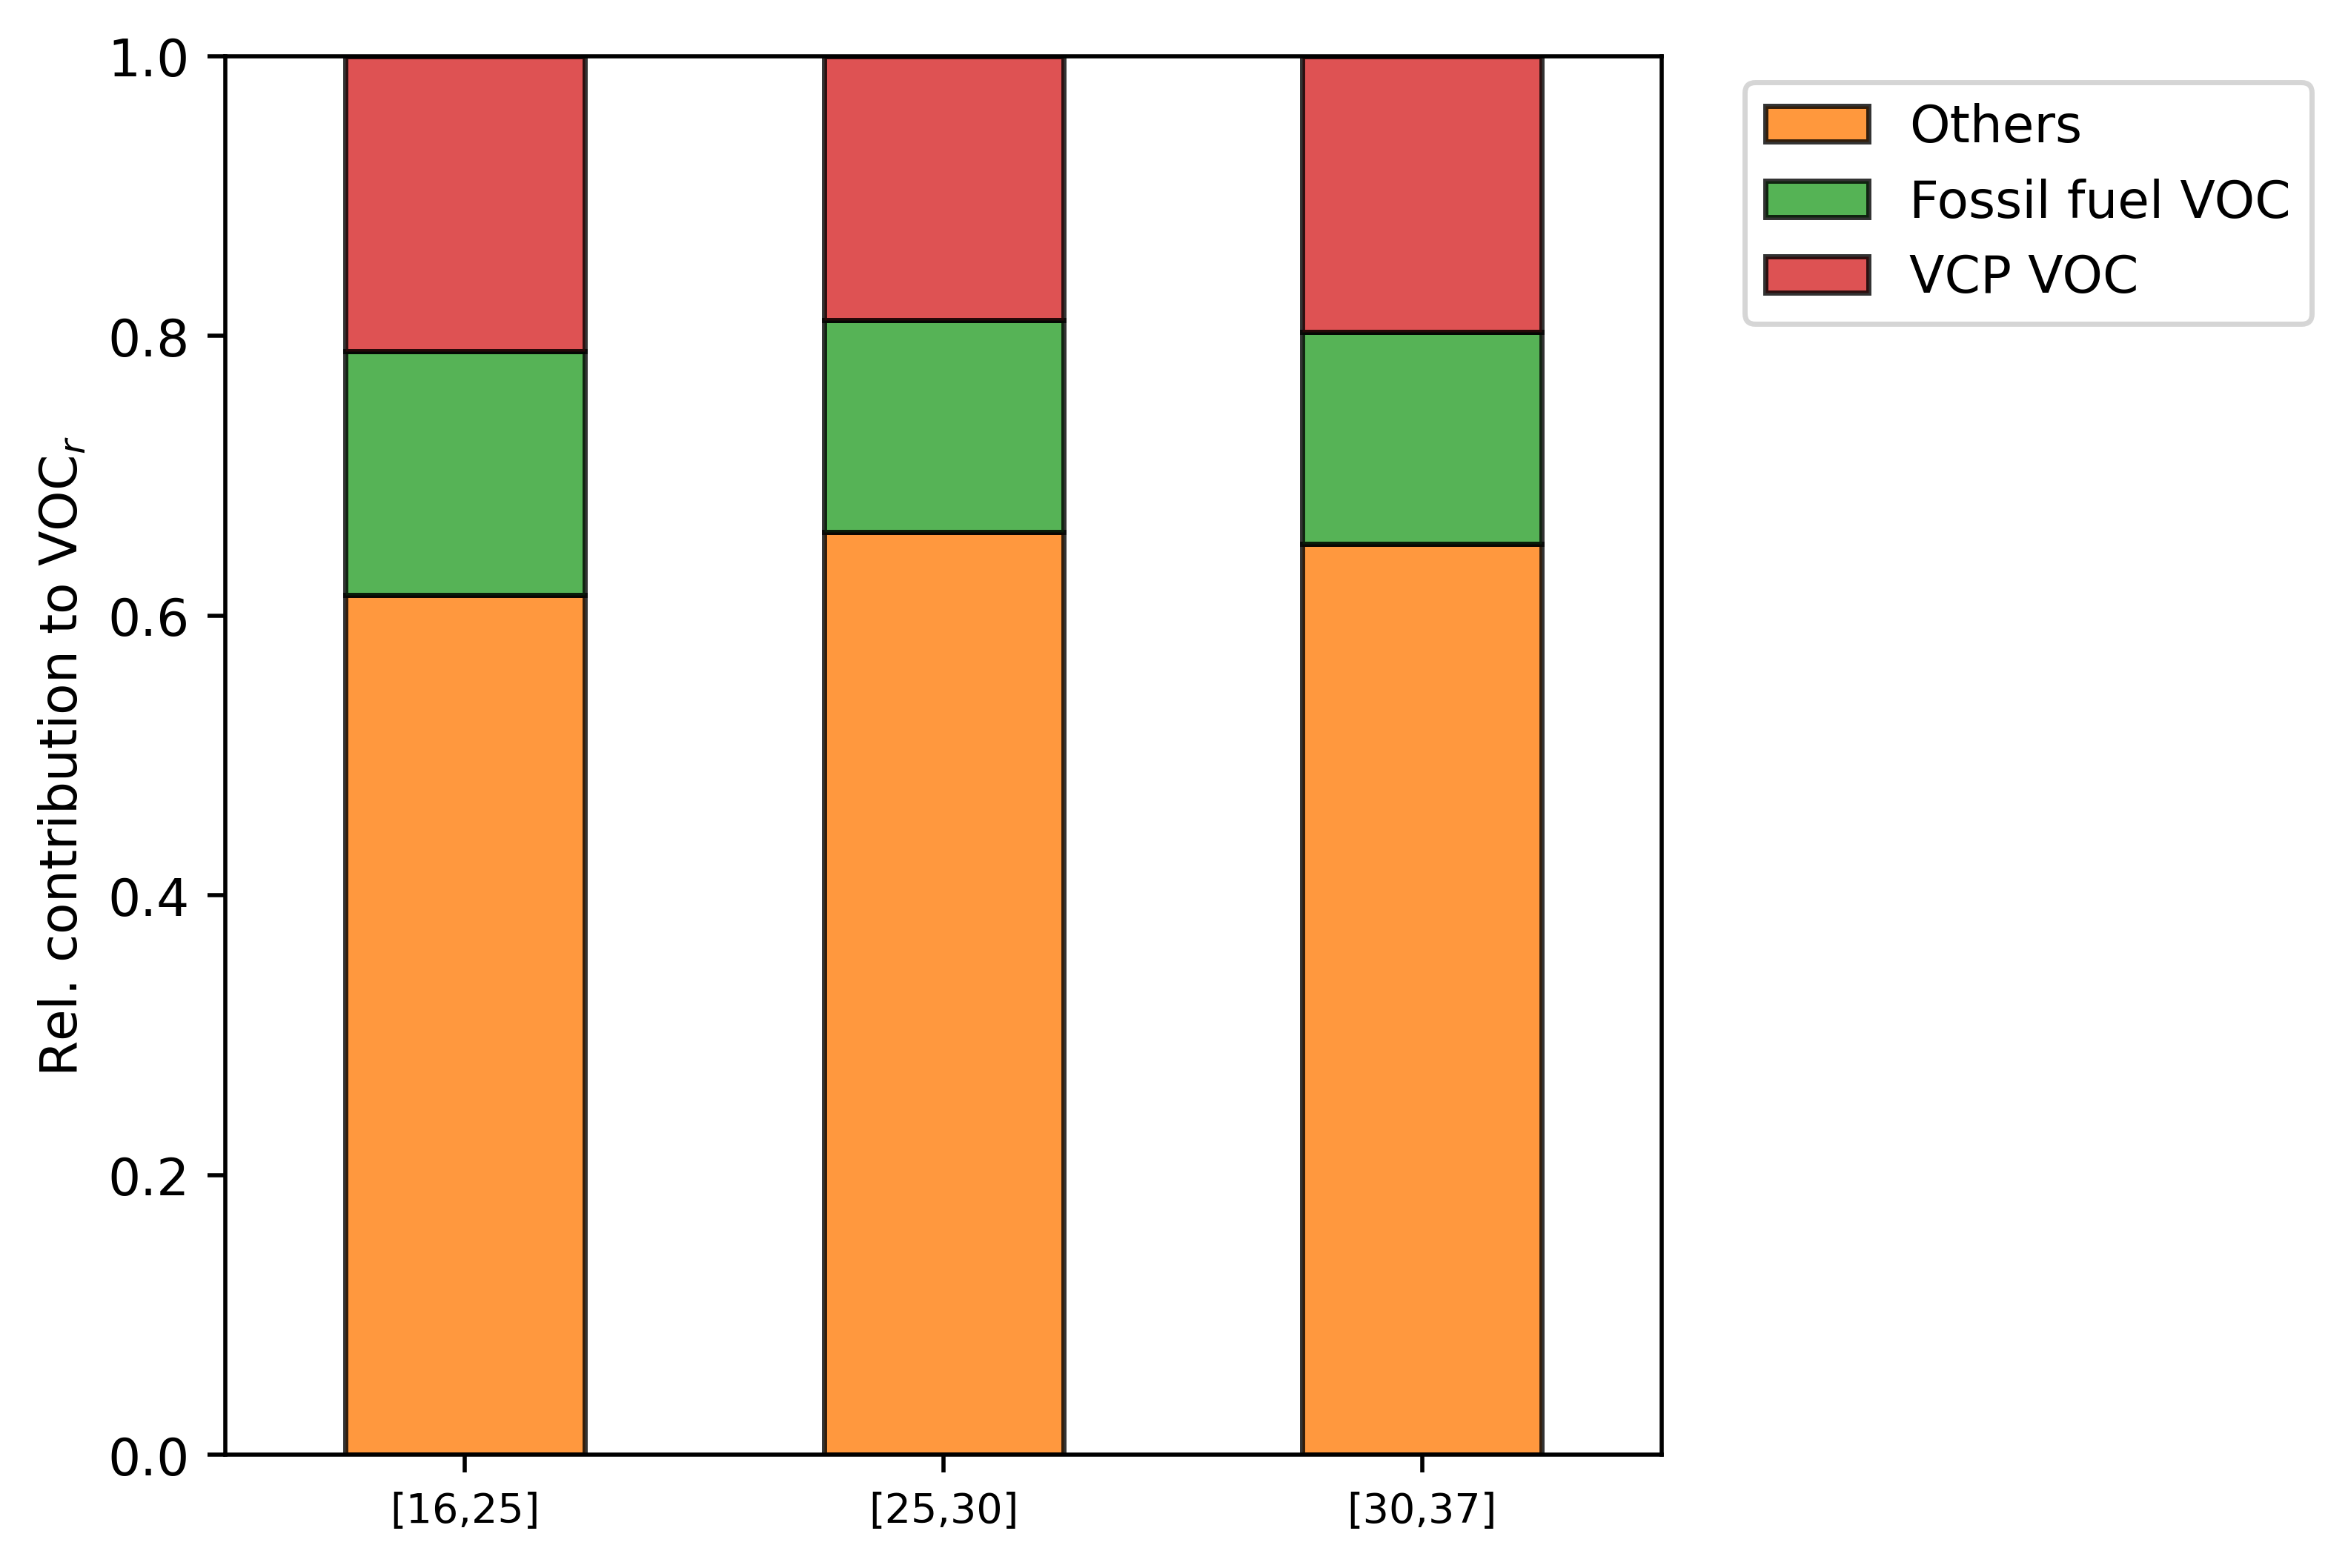

In [20]:
fig, axs = plt.subplots(1,1,figsize=(5,5),dpi=500)
boxcolors = ['tab:orange','tab:green','tab:red']
o3_daily_temp_ratio.plot(kind='bar', stacked=True, ax=axs,color=boxcolors, edgecolor='black',alpha=0.8, rot=0)
axs.set_xticks(o3_daily_temp_ratio.index,['[16,25]','[25,30]','[30,37]'], fontsize=8,rotation=0)
#axs.set_xticks(o3_daily_temp_ratio.index,['[21,27]','[27,30]','[30,35]'], fontsize=8,rotation=0)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylim([0,1])
plt.ylabel('Rel. contribution to VOC$_r$')
plt.xlabel('')

In [21]:
o3_daily_temp_ratio

,Others,Fossil fuel VOC,VCP VOC
temp_bin_index,,,
0.0,0.614833,0.174062,0.211105
1.0,0.659588,0.151685,0.188728
2.0,0.651171,0.151860,0.196969


In [12]:
#o3
temp_bin = pd.read_csv(analysis_dataset_path+'temp_bin.csv')
indx = pd.to_datetime(temp_bin['date']).dt.month == 8
temp_bin = temp_bin.loc[indx,:].loc[:59,:]

In [53]:
#evenly cut the 30 days into 3 temp bins
bins = pd.qcut(temp_bin['TEMP'],3,labels=False)
temp_bin_index = bins.values
#[(21.656, 27.027] < (27.027, 29.99] < (29.99, 34.434]]

In [23]:
temp_bin_index = temp_bin['temp_bin_index'].values

In [20]:
this_day = 1
output_filename_thisday = datapath + '2021-08-{:02d}-'.format(this_day) + 'no2_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t2_4km.nc'
ds = xr.open_dataset(output_filename_thisday)
t = ds['__xarray_dataarray_variable__']

In [21]:
t.shape

(11, 324, 264)

In [24]:
#each day
recap_days = list(range(1,31))
datapath = analysis_dataset_path+'surf_map/'
filenames = ['wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t1_4km',
             'wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t2_4km',
             'wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t3_4km']

gdfs_tot = []
xlim =  [-118.6,-117.1]
ylim = [33.5,34.2] 
for i_day, this_day in enumerate(recap_days):
    mda8_o3_tots = []
    pans_tots = []
    nox_tots = []
    ts_tots = []
    
    for filename in filenames:
        #for this_day in recap_days:
        output_filename_thisday = datapath + '2021-08-{:02d}-'.format(this_day) + 'mda8o3_' +filename+'.nc'
        ds = xr.open_dataset(output_filename_thisday)
        mda8_o3 = ds['__xarray_dataarray_variable__']
        mda8_o3_tot = mda8_o3
        mda8_o3_tots.append(mda8_o3_tot)
        
        output_filename_thisday = datapath + '2021-08-{:02d}-'.format(this_day) + 'T_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t2_4km.nc'
        ds = xr.open_dataset(output_filename_thisday)
        t = ds['__xarray_dataarray_variable__']
        ts_tots.append(t)
        
        output_filename_thisday = datapath + '2021-08-{:02d}-'.format(this_day) + 'pan_' +filename+'.nc'
        ds = xr.open_dataset(output_filename_thisday)
        pan = ds['__xarray_dataarray_variable__']
        pans_tots.append(pan*1e3)
        
        output_filename_thisday = datapath + '2021-08-{:02d}-'.format(this_day) + 'no_' +filename+'.nc'
        ds = xr.open_dataset(output_filename_thisday)
        no = ds['__xarray_dataarray_variable__']
        
        output_filename_thisday = datapath + '2021-08-{:02d}-'.format(this_day) + 'no2_' +filename+'.nc'
        ds = xr.open_dataset(output_filename_thisday)
        no2 = ds['__xarray_dataarray_variable__']
        nox_tots.append(no*1e3 + no2*1e3)

    gdfs = []
    for mda8_o3_tot, ts_tot, pans_tot, nox_tot in zip(mda8_o3_tots,ts_tots,pans_tots,nox_tots):
        o3 = mda8_o3_tot.values
        t = ts_tot.values
        t = np.mean(t,axis=0)
        pan = pans_tot.values
        pan = np.mean(pan,axis=0)
        nox = nox_tot.values
        nox = np.mean(nox,axis=0)
        
        df_wrf = pd.DataFrame(data={'lon':lon.flatten(), 'lat':lat.flatten(),'o3':o3.flatten(),'T':t.flatten(),'pan':pan.flatten(),
                                    'nox':nox.flatten(),'cls_indxs':cls_indxs.flatten(),
                               'clon1':clon1.flatten(), 'clon2':clon2.flatten(),'clon3':clon3.flatten(),'clon4':clon4.flatten(),
                               'clat1':clat1.flatten(), 'clat2':clat2.flatten(),'clat3':clat3.flatten(),'clat4':clat4.flatten()})

        indx = (df_wrf['lon'] >= xlim[0]) & (df_wrf['lon'] <= xlim[1]) & (df_wrf['lat'] >= ylim[0]) & (df_wrf['lat'] <= ylim[1])
        #indx =area_indx == 1
        df_wrf = df_wrf.loc[indx,:]
        geometry_polygon = [Polygon([[df_wrf.loc[i,'clon1'], df_wrf.loc[i,'clat1']],
                [df_wrf.loc[i,'clon2'], df_wrf.loc[i,'clat2']],
                [df_wrf.loc[i,'clon3'], df_wrf.loc[i,'clat3']],
                [df_wrf.loc[i,'clon4'], df_wrf.loc[i,'clat4']]]) for i in df_wrf.index]
        gdf = gpd.GeoDataFrame(df_wrf, geometry=geometry_polygon)
        gdf.loc[:,'index'] = range(gdf.shape[0])
        gdf.loc[:,'temp_bin_index'] = temp_bin_index[i_day]
        #gdf = gdf.groupby(['clon1','clon2','clon3','clon4','clat1','clat2','clat3','clat4']).agg('mean').reset_index()
        gdf = gdf.set_crs('epsg:4326',allow_override=True)
        gdfs.append(gdf)

    gdfs_tot.append(gdfs)

In [30]:
def calculate_temp_dependence_o3(spc):
    o3_daily = pd.DataFrame()

    for i_day, this_day in enumerate(recap_days):
        gdfs = gdfs_tot[i_day]
        west_indx = gdfs[1]['lon']<=-117.8
        o3_daily.loc[2*i_day,'VCP VOC'] = gdfs[1].loc[west_indx,spc].mean() - gdfs[2].loc[west_indx,spc].mean()
        o3_daily.loc[2*i_day,'Fossil fuel VOC'] = gdfs[2].loc[west_indx,spc].mean() - gdfs[0].loc[west_indx,spc] .mean()
        o3_daily.loc[2*i_day,'Background'] = 30
        o3_daily.loc[2*i_day,'Others'] = gdfs[0].loc[west_indx,spc].mean()-30
        o3_daily.loc[2*i_day,'tot'] = gdfs[1].loc[west_indx,spc].mean()
        o3_daily.loc[2*i_day,'temp_bin_index'] = temp_bin_index[i_day]
        o3_daily.loc[2*i_day,'location'] = 'West/Central LA'

        east_indx = gdfs[1]['lon']>-117.8
        o3_daily.loc[2*i_day+1,'VCP VOC'] = gdfs[1].loc[east_indx,spc].mean() - gdfs[2].loc[east_indx,spc].mean()
        o3_daily.loc[2*i_day+1,'Fossil fuel VOC'] = gdfs[2].loc[east_indx,spc].mean() - gdfs[0].loc[east_indx,spc] .mean()
        o3_daily.loc[2*i_day+1,'Background'] = 30
        o3_daily.loc[2*i_day+1,'Others'] = gdfs[0].loc[east_indx,spc].mean()-30
        o3_daily.loc[2*i_day+1,'tot'] = gdfs[1].loc[east_indx,spc].mean()
        o3_daily.loc[2*i_day+1,'temp_bin_index'] = temp_bin_index[i_day]+4
        o3_daily.loc[2*i_day+1,'location'] = 'East basin'
    o3_daily.loc[60,'temp_bin_index']=3
    o3_daily.loc[60,'location']='East basin'   
    o3_daily_temp = o3_daily.groupby(['location','temp_bin_index']).mean()
    o3_daily_temp['VCP VOC ratio'] = o3_daily_temp['VCP VOC']/o3_daily_temp['tot']
    o3_daily_temp['Background ratio'] = o3_daily_temp['Background']/o3_daily_temp['tot']
    o3_daily_temp['Fossil fuel VOC ratio'] = o3_daily_temp['Fossil fuel VOC']/o3_daily_temp['tot']
    o3_daily_temp['Others ratio'] = o3_daily_temp['Others']/o3_daily_temp['tot']
    o3_daily_temp = o3_daily_temp.reset_index().set_index('temp_bin_index')
    o3_daily_temp_ratio = o3_daily_temp.loc[:,['Background ratio','Others ratio','Fossil fuel VOC ratio','VCP VOC ratio','location']]
    
    
    o3_daily_temp_ratio_nobkg = o3_daily_temp
    o3_daily_temp_ratio_nobkg['VCP VOC ratio'] = o3_daily_temp['VCP VOC']/(o3_daily_temp['tot']-30)
    o3_daily_temp_ratio_nobkg['Fossil fuel VOC ratio'] = o3_daily_temp['Fossil fuel VOC']/(o3_daily_temp['tot']-30)
    o3_daily_temp_ratio_nobkg['Others ratio'] = o3_daily_temp['Others']/(o3_daily_temp['tot']-30)
    o3_daily_temp_ratio_nobkg = o3_daily_temp_ratio_nobkg.loc[:,['Others ratio','Fossil fuel VOC ratio','VCP VOC ratio','location']]
    
    return o3_daily_temp, o3_daily_temp_ratio,o3_daily_temp_ratio_nobkg

def calculate_temp_dependence(spc):
    o3_daily = pd.DataFrame()

    for i_day, this_day in enumerate(recap_days):
        gdfs = gdfs_tot[i_day]
        west_indx = gdfs[1]['lon']<=-117.8
        o3_daily.loc[2*i_day,'VCP VOC'] = gdfs[1].loc[west_indx,spc].mean() - gdfs[2].loc[west_indx,spc].mean()
        o3_daily.loc[2*i_day,'Fossil fuel VOC'] = gdfs[2].loc[west_indx,spc].mean() - gdfs[0].loc[west_indx,spc] .mean()
        o3_daily.loc[2*i_day,'Others'] = gdfs[0].loc[west_indx,spc].mean()
        o3_daily.loc[2*i_day,'tot'] = gdfs[1].loc[west_indx,spc].mean()
        o3_daily.loc[2*i_day,'temp_bin_index'] = temp_bin_index[i_day]
        o3_daily.loc[2*i_day,'location'] = 'West/Central LA'

        east_indx = gdfs[1]['lon']>-117.8
        o3_daily.loc[2*i_day+1,'VCP VOC'] = gdfs[1].loc[east_indx,spc].mean() - gdfs[2].loc[east_indx,spc].mean()
        o3_daily.loc[2*i_day+1,'Fossil fuel VOC'] = gdfs[2].loc[east_indx,spc].mean() - gdfs[0].loc[east_indx,spc] .mean()
        o3_daily.loc[2*i_day+1,'Others'] = gdfs[0].loc[east_indx,spc].mean()
        o3_daily.loc[2*i_day+1,'tot'] = gdfs[1].loc[east_indx,spc].mean()
        o3_daily.loc[2*i_day+1,'temp_bin_index'] = temp_bin_index[i_day]+4
        o3_daily.loc[2*i_day+1,'location'] = 'East basin'
    o3_daily.loc[60,'temp_bin_index']=3
    o3_daily.loc[60,'location']='East basin'   
    o3_daily_temp = o3_daily.groupby(['location','temp_bin_index']).mean()
    o3_daily_temp['VCP VOC ratio'] = o3_daily_temp['VCP VOC']/o3_daily_temp['tot']
    o3_daily_temp['Fossil fuel VOC ratio'] = o3_daily_temp['Fossil fuel VOC']/o3_daily_temp['tot']
    o3_daily_temp['Others ratio'] = o3_daily_temp['Others']/o3_daily_temp['tot']
    o3_daily_temp = o3_daily_temp.reset_index().set_index('temp_bin_index')
    o3_daily_temp_ratio = o3_daily_temp.loc[:,['Others ratio','Fossil fuel VOC ratio','VCP VOC ratio','location']]
    
    return o3_daily_temp, o3_daily_temp_ratio


Text(0, 0.5, 'Rel. contribution to MDA8 O$_3$')

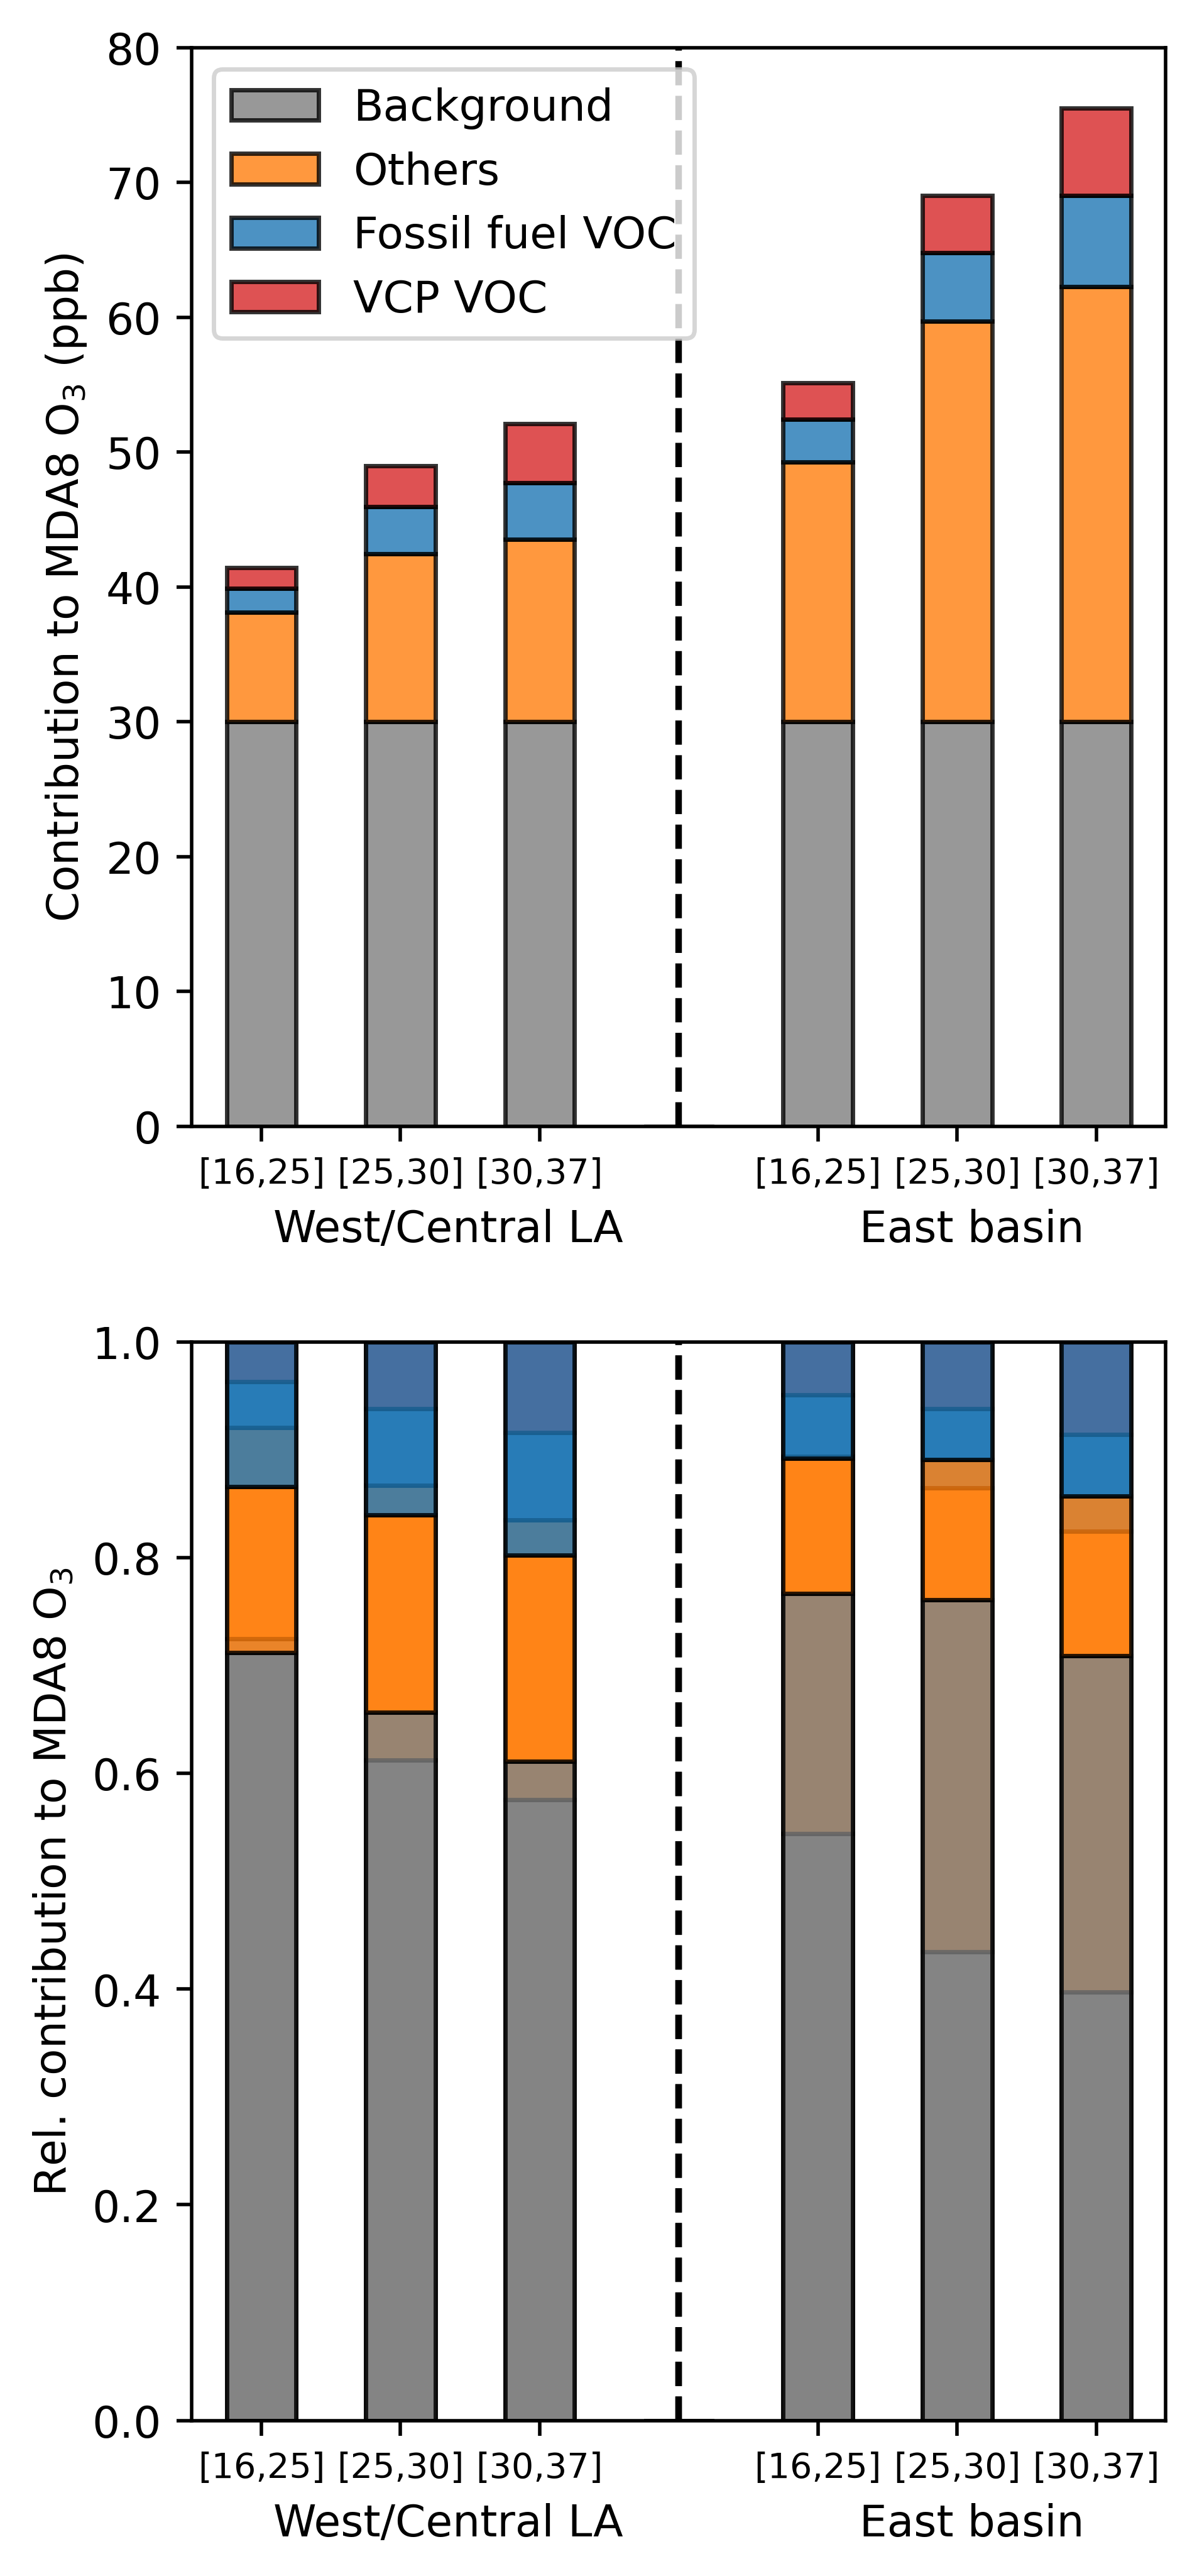

In [36]:
o3_daily_temp, o3_daily_temp_ratio,o3_daily_temp_ratio_nobkg = calculate_temp_dependence_o3('o3')
label = 'MDA8 O$_3$'
fig, axs = plt.subplots(3,1,figsize=(4,10),dpi=500)
boxcolors = ['tab:gray','tab:orange','tab:blue','tab:red']
o3_daily_temp.loc[:,['Background','Others','Fossil fuel VOC','VCP VOC']].sort_index().plot(kind='bar', stacked=True, ax=axs[0], color=boxcolors,edgecolor='black',alpha=0.8, rot=0,legend=True,label=['Background (30 ppb)','Others','Fossil fuel VOC','VCP VOC'])
#o3_daily_temp[o3_daily_temp['location']=='East basin'].loc[:,['background','others','fossil','VCP']].plot(kind='bar', stacked=True, ax=axs[0], edgecolor='black',alpha=0.8, rot=0)
axs[0].set_xticks([0,1,2,4,5,6],['[16,25]','[25,30]','[30,37]','[16,25]','[25,30]','[30,37]'], fontsize=8,rotation=0)
axs[0].plot([3,3],[0,85],color='k',linestyle='--')
axs[0].set_ylim([0,80])
axs[0].set_xlabel('West/Central LA                 East basin')
axs[0].set_ylabel('Contribution to {} (ppb)'.format(label))

o3_daily_temp_ratio.sort_index().plot(kind='bar', stacked=True, ax=axs[1], color=boxcolors,edgecolor='black',alpha=0.8, rot=0,legend=False)
#o3_daily_temp[o3_daily_temp['location']=='East basin'].loc[:,['background','others','fossil','VCP']].plot(kind='bar', stacked=True, ax=axs[0], edgecolor='black',alpha=0.8, rot=0)
axs[1].set_xticks([0,1,2,4,5,6],['[16,25]','[25,30]','[30,37]','[16,25]','[25,30]','[30,37]'], fontsize=8,rotation=0)
axs[1].plot([3,3],[0,1],color='k',linestyle='--')
axs[1].set_ylim([0,1])
axs[1].set_xlabel('West/Central LA                 East basin')
axs[1].set_ylabel('Rel. contribution to {}'.format(label))
#plt.text(-1.13, -0.1, 'West/Central LA', fontsize=10)
#plt.text(-0.53, -0.1, 'East basin', fontsize=10)


Text(0, 0.5, 'Rel. contribution to \n local enhancement of MDA8 O$_3$')

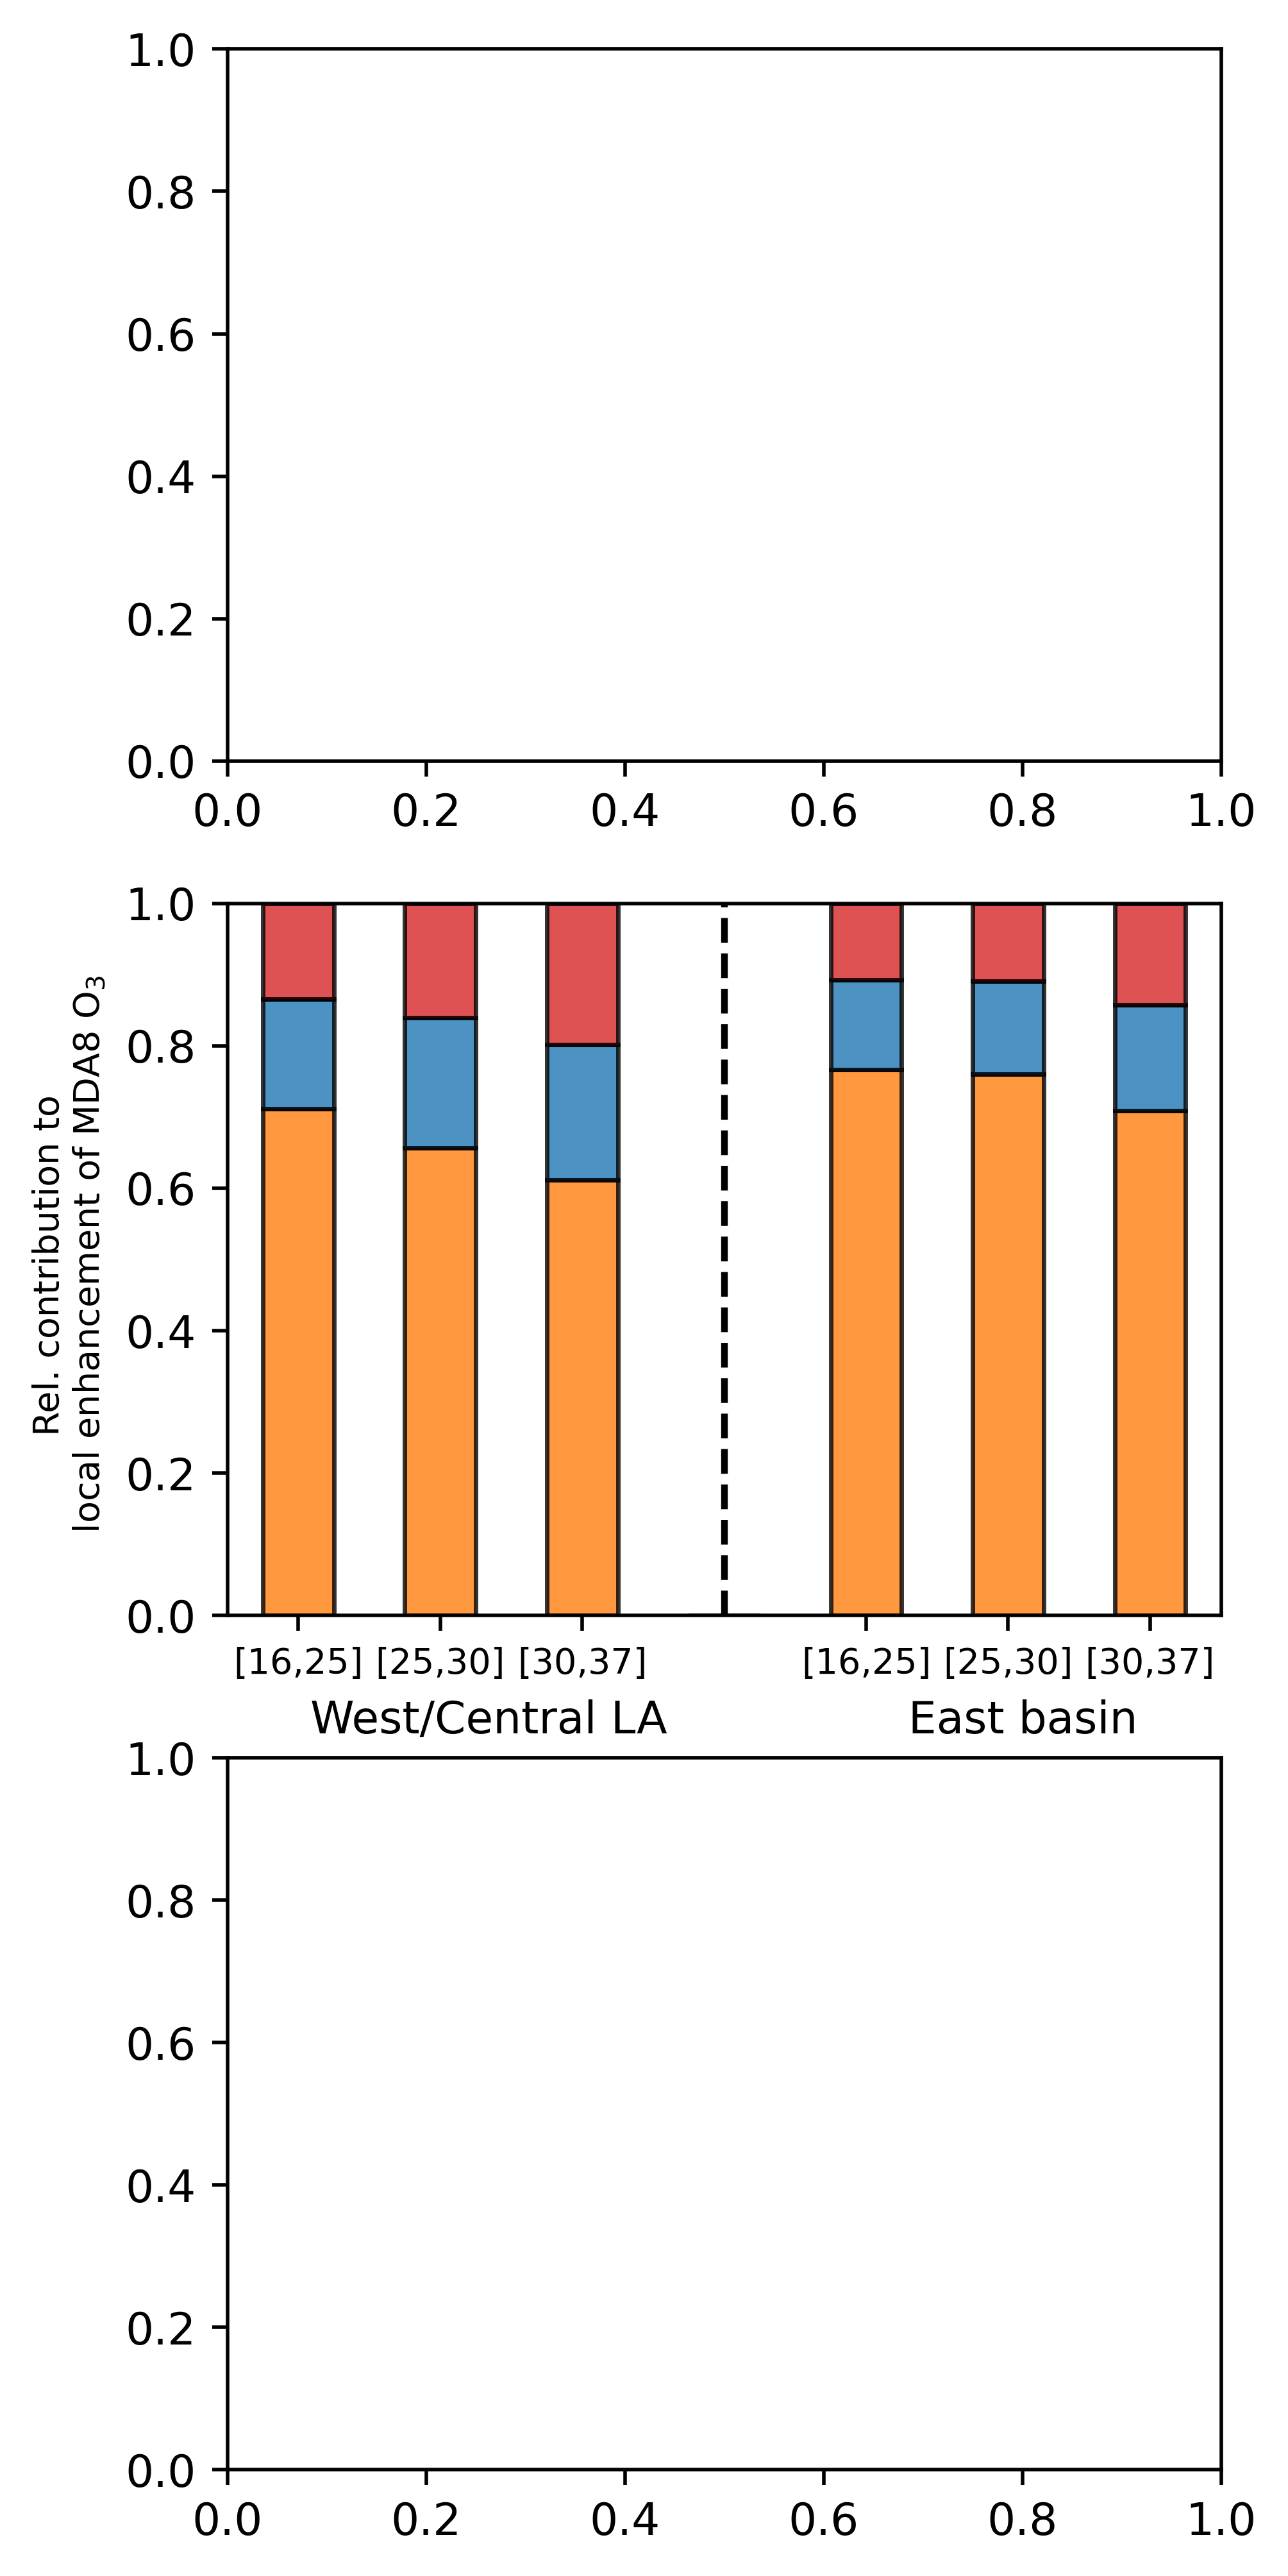

In [41]:
fig, axs = plt.subplots(3,1,figsize=(4,10),dpi=500)
o3_daily_temp_ratio_nobkg.sort_index().plot(kind='bar', stacked=True, ax=axs[1], color=['tab:orange','tab:blue','tab:red'],edgecolor='black',alpha=0.8, rot=0,legend=False)
#o3_daily_temp[o3_daily_temp['location']=='East basin'].loc[:,['background','others','fossil','VCP']].plot(kind='bar', stacked=True, ax=axs[0], edgecolor='black',alpha=0.8, rot=0)
axs[1].set_xticks([0,1,2,4,5,6],['[16,25]','[25,30]','[30,37]','[16,25]','[25,30]','[30,37]'], fontsize=8,rotation=0)
axs[1].plot([3,3],[0,1],color='k',linestyle='--')
axs[1].set_ylim([0,1])
axs[1].set_xlabel('West/Central LA                 East basin')
axs[1].set_ylabel('Rel. contribution to \n local enhancement of {}'.format(label),fontsize=8)
#plt.text(-1.13, -0.1, 'West/Central LA', fontsize=10)
#plt.text(-0.53, -0.1, 'East basin', fontsize=10)

In [42]:
0.89+0.86

1.75

In [43]:
5.7+4.9

10.600000000000001

In [27]:
o3_daily_temp_ratio

,Background ratio,Others ratio,Fossil fuel VOC ratio,VCP VOC ratio,location
temp_bin_index,,,,,
3.0,NaN,NaN,NaN,NaN,East basin
4.0,0.543994,0.349608,0.057229,0.049169,East basin
5.0,0.434478,0.430151,0.073573,0.061797,East basin
6.0,0.397249,0.427417,0.089297,0.086037,East basin
0.0,0.724502,0.196086,0.042482,0.036931,West/Central LA
1.0,0.612508,0.254497,0.070819,0.062176,West/Central LA
2.0,0.575623,0.259402,0.080958,0.084016,West/Central LA


Text(0, 0.5, 'Rel. contribution to NO$_x$')

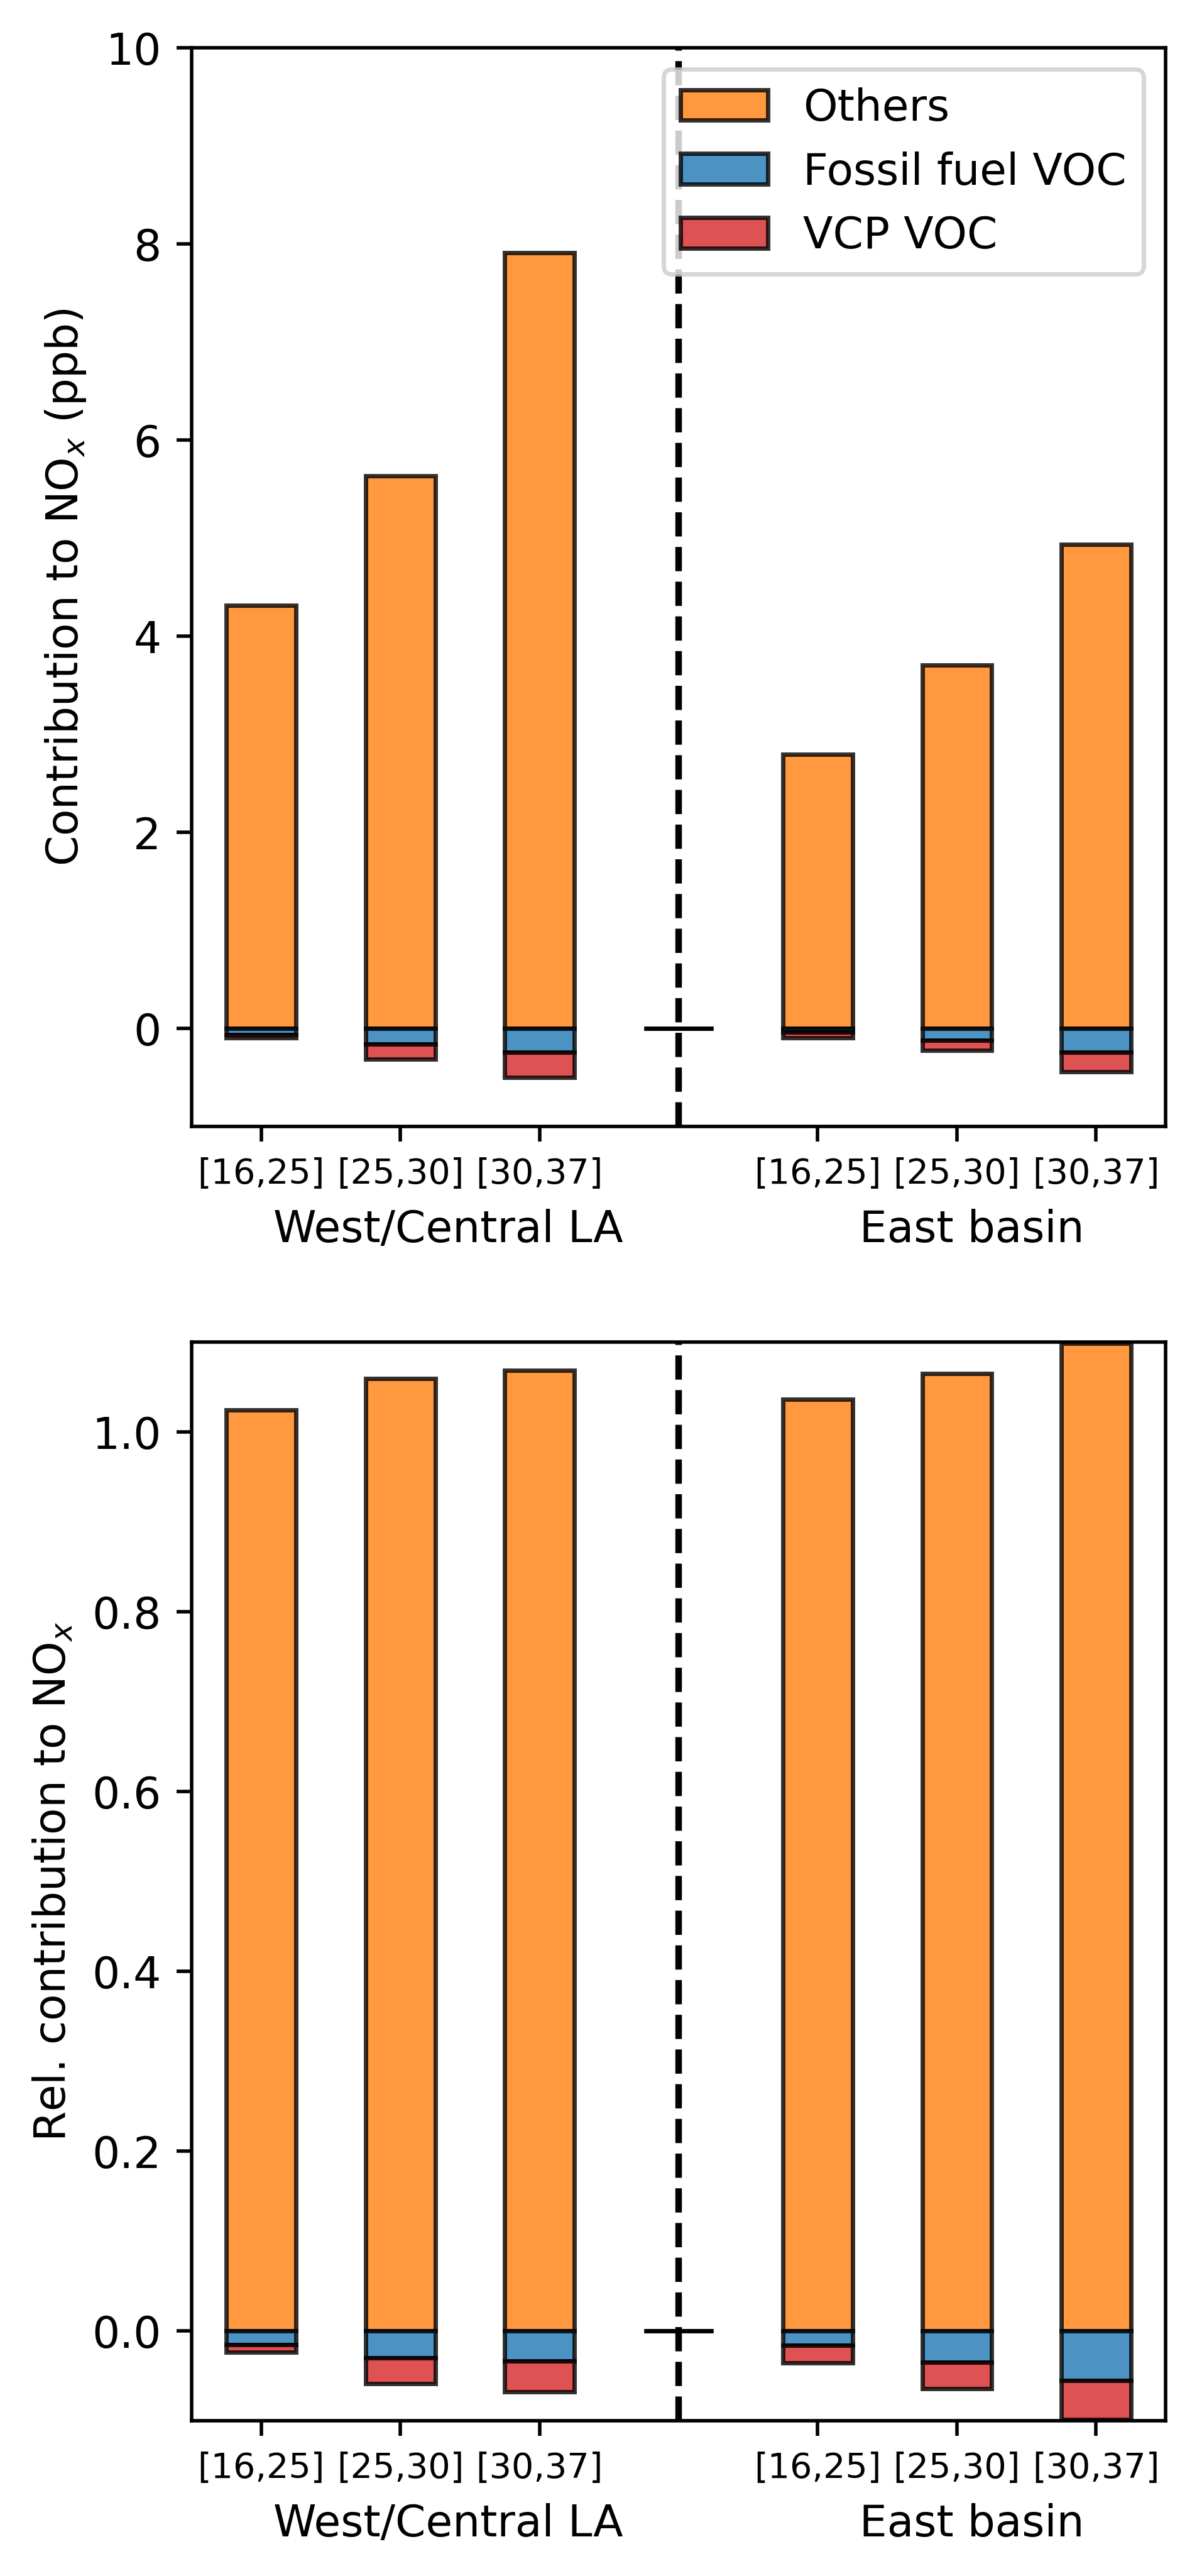

In [193]:
o3_daily_temp, o3_daily_temp_ratio = calculate_temp_dependence('nox')
label = 'NO$_x$'
fig, axs = plt.subplots(2,1,figsize=(4,10),dpi=500)
boxcolors = ['tab:orange','tab:blue','tab:red']
o3_daily_temp.loc[:,['Others','Fossil fuel VOC','VCP VOC']].sort_index().plot(kind='bar', stacked=True, ax=axs[0], color=boxcolors,edgecolor='black',alpha=0.8, rot=0,legend=True,label=['Background (30 ppb)','Others','Fossil fuel VOC','VCP VOC'])
#o3_daily_temp[o3_daily_temp['location']=='East basin'].loc[:,['background','others','fossil','VCP']].plot(kind='bar', stacked=True, ax=axs[0], edgecolor='black',alpha=0.8, rot=0)
axs[0].set_xticks([0,1,2,4,5,6],['[16,25]','[25,30]','[30,37]','[16,25]','[25,30]','[30,37]'], fontsize=8,rotation=0)
axs[0].plot([3,3],[-1,10],color='k',linestyle='--')
axs[0].set_ylim([-1,10])
axs[0].set_xlabel('West/Central LA                 East basin')
axs[0].set_ylabel('Contribution to {} (ppb)'.format(label))

o3_daily_temp_ratio.sort_index().plot(kind='bar', stacked=True, ax=axs[1], color=boxcolors,edgecolor='black',alpha=0.8, rot=0,legend=False)
#o3_daily_temp[o3_daily_temp['location']=='East basin'].loc[:,['background','others','fossil','VCP']].plot(kind='bar', stacked=True, ax=axs[0], edgecolor='black',alpha=0.8, rot=0)
axs[1].set_xticks([0,1,2,4,5,6],['[16,25]','[25,30]','[30,37]','[16,25]','[25,30]','[30,37]'], fontsize=8,rotation=0)
axs[1].plot([3,3],[-0.1,1.1],color='k',linestyle='--')
axs[1].set_ylim([-0.1,1.1])
axs[1].set_xlabel('West/Central LA                 East basin')
axs[1].set_ylabel('Rel. contribution to {}'.format(label))
#plt.text(-1.13, -0.1, 'West/Central LA', fontsize=10)
#plt.text(-0.53, -0.1, 'East basin', fontsize=10)

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (3).

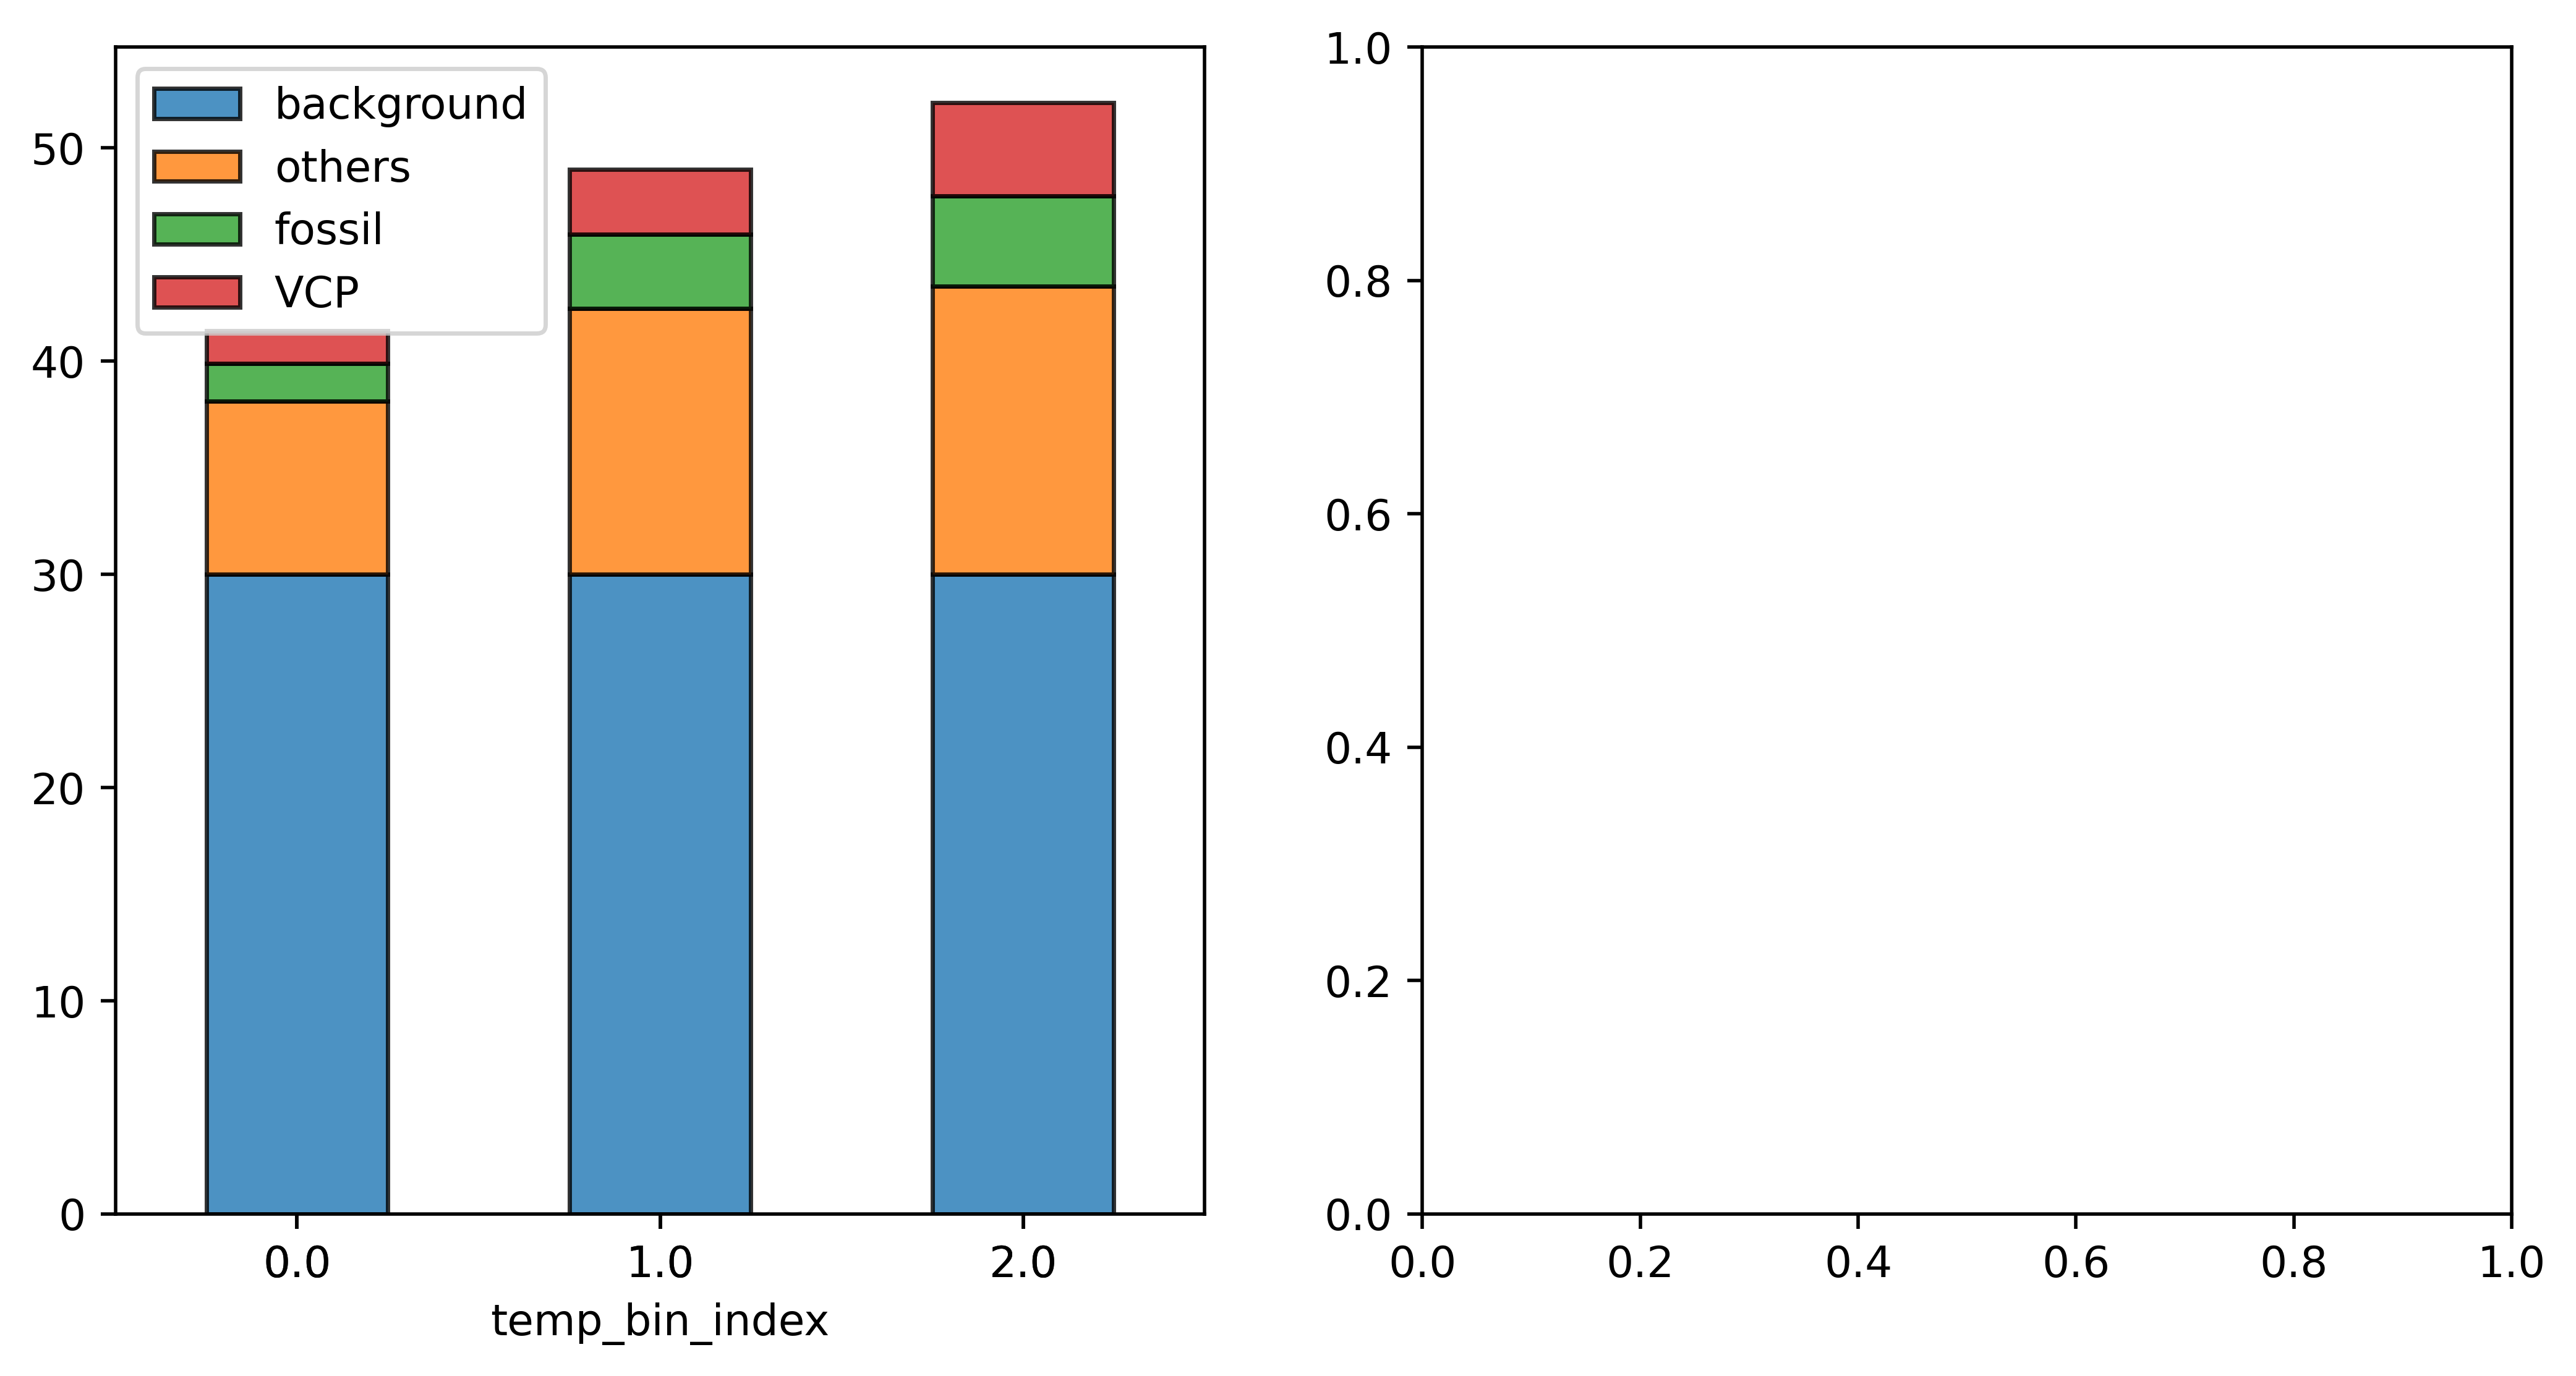

In [76]:
fig, axs = plt.subplots(1,2,figsize=(10,5),dpi=500)
boxcolors = ['white','tab:gray','tab:blue','tab:red']
o3_daily_temp[o3_daily_temp['location']=='West/Central LA'].loc[:,['background','others','fossil','VCP']].plot(kind='bar', stacked=True, ax=axs[0], edgecolor='black',alpha=0.8, rot=0)
axs[0].set_xticks(o3_daily_temp_ratio.index,['[16,25]','[25,30]','[30,37]'], fontsize=8,rotation=0)
#axs.set_xticks(o3_daily_temp_ratio.index,['[21,27]','[27,30]','[30,35]'], fontsize=8,rotation=0)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.ylim([0,1])
plt.ylabel('Contribution to MDA8 O$_3$')
plt.xlabel('')

o3_daily_temp_ratio.plot(kind='bar', stacked=True, ax=axs[1], edgecolor='black',alpha=0.8, rot=0)
#axs.set_xticks(o3_daily_temp_ratio.index,['[16,25]','[25,30]','[30,37]'], fontsize=8,rotation=0)
axs.set_xticks(o3_daily_temp_ratio.index,['[21,27]','[27,30]','[30,35]'], fontsize=8,rotation=0)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylim([0,1])
plt.ylabel('Rel. contribution to MDA8 O$_3$')
plt.xlabel('')

In [25]:
o3_daily_temp = o3_daily.groupby('temp_bin_index').mean()
o3_daily_temp['VCP VOC'] = o3_daily_temp['VCP']/o3_daily_temp['tot']
o3_daily_temp['Background (30 ppb)'] = o3_daily_temp['background']/o3_daily_temp['tot']
o3_daily_temp['Fossil fuel VOC'] = o3_daily_temp['fossil']/o3_daily_temp['tot']
o3_daily_temp['Others'] = o3_daily_temp['others']/o3_daily_temp['tot']
o3_daily_temp_ratio = o3_daily_temp.loc[:,['Background (30 ppb)','Others','Fossil fuel VOC','VCP VOC']]

Text(0.5, 0, '')

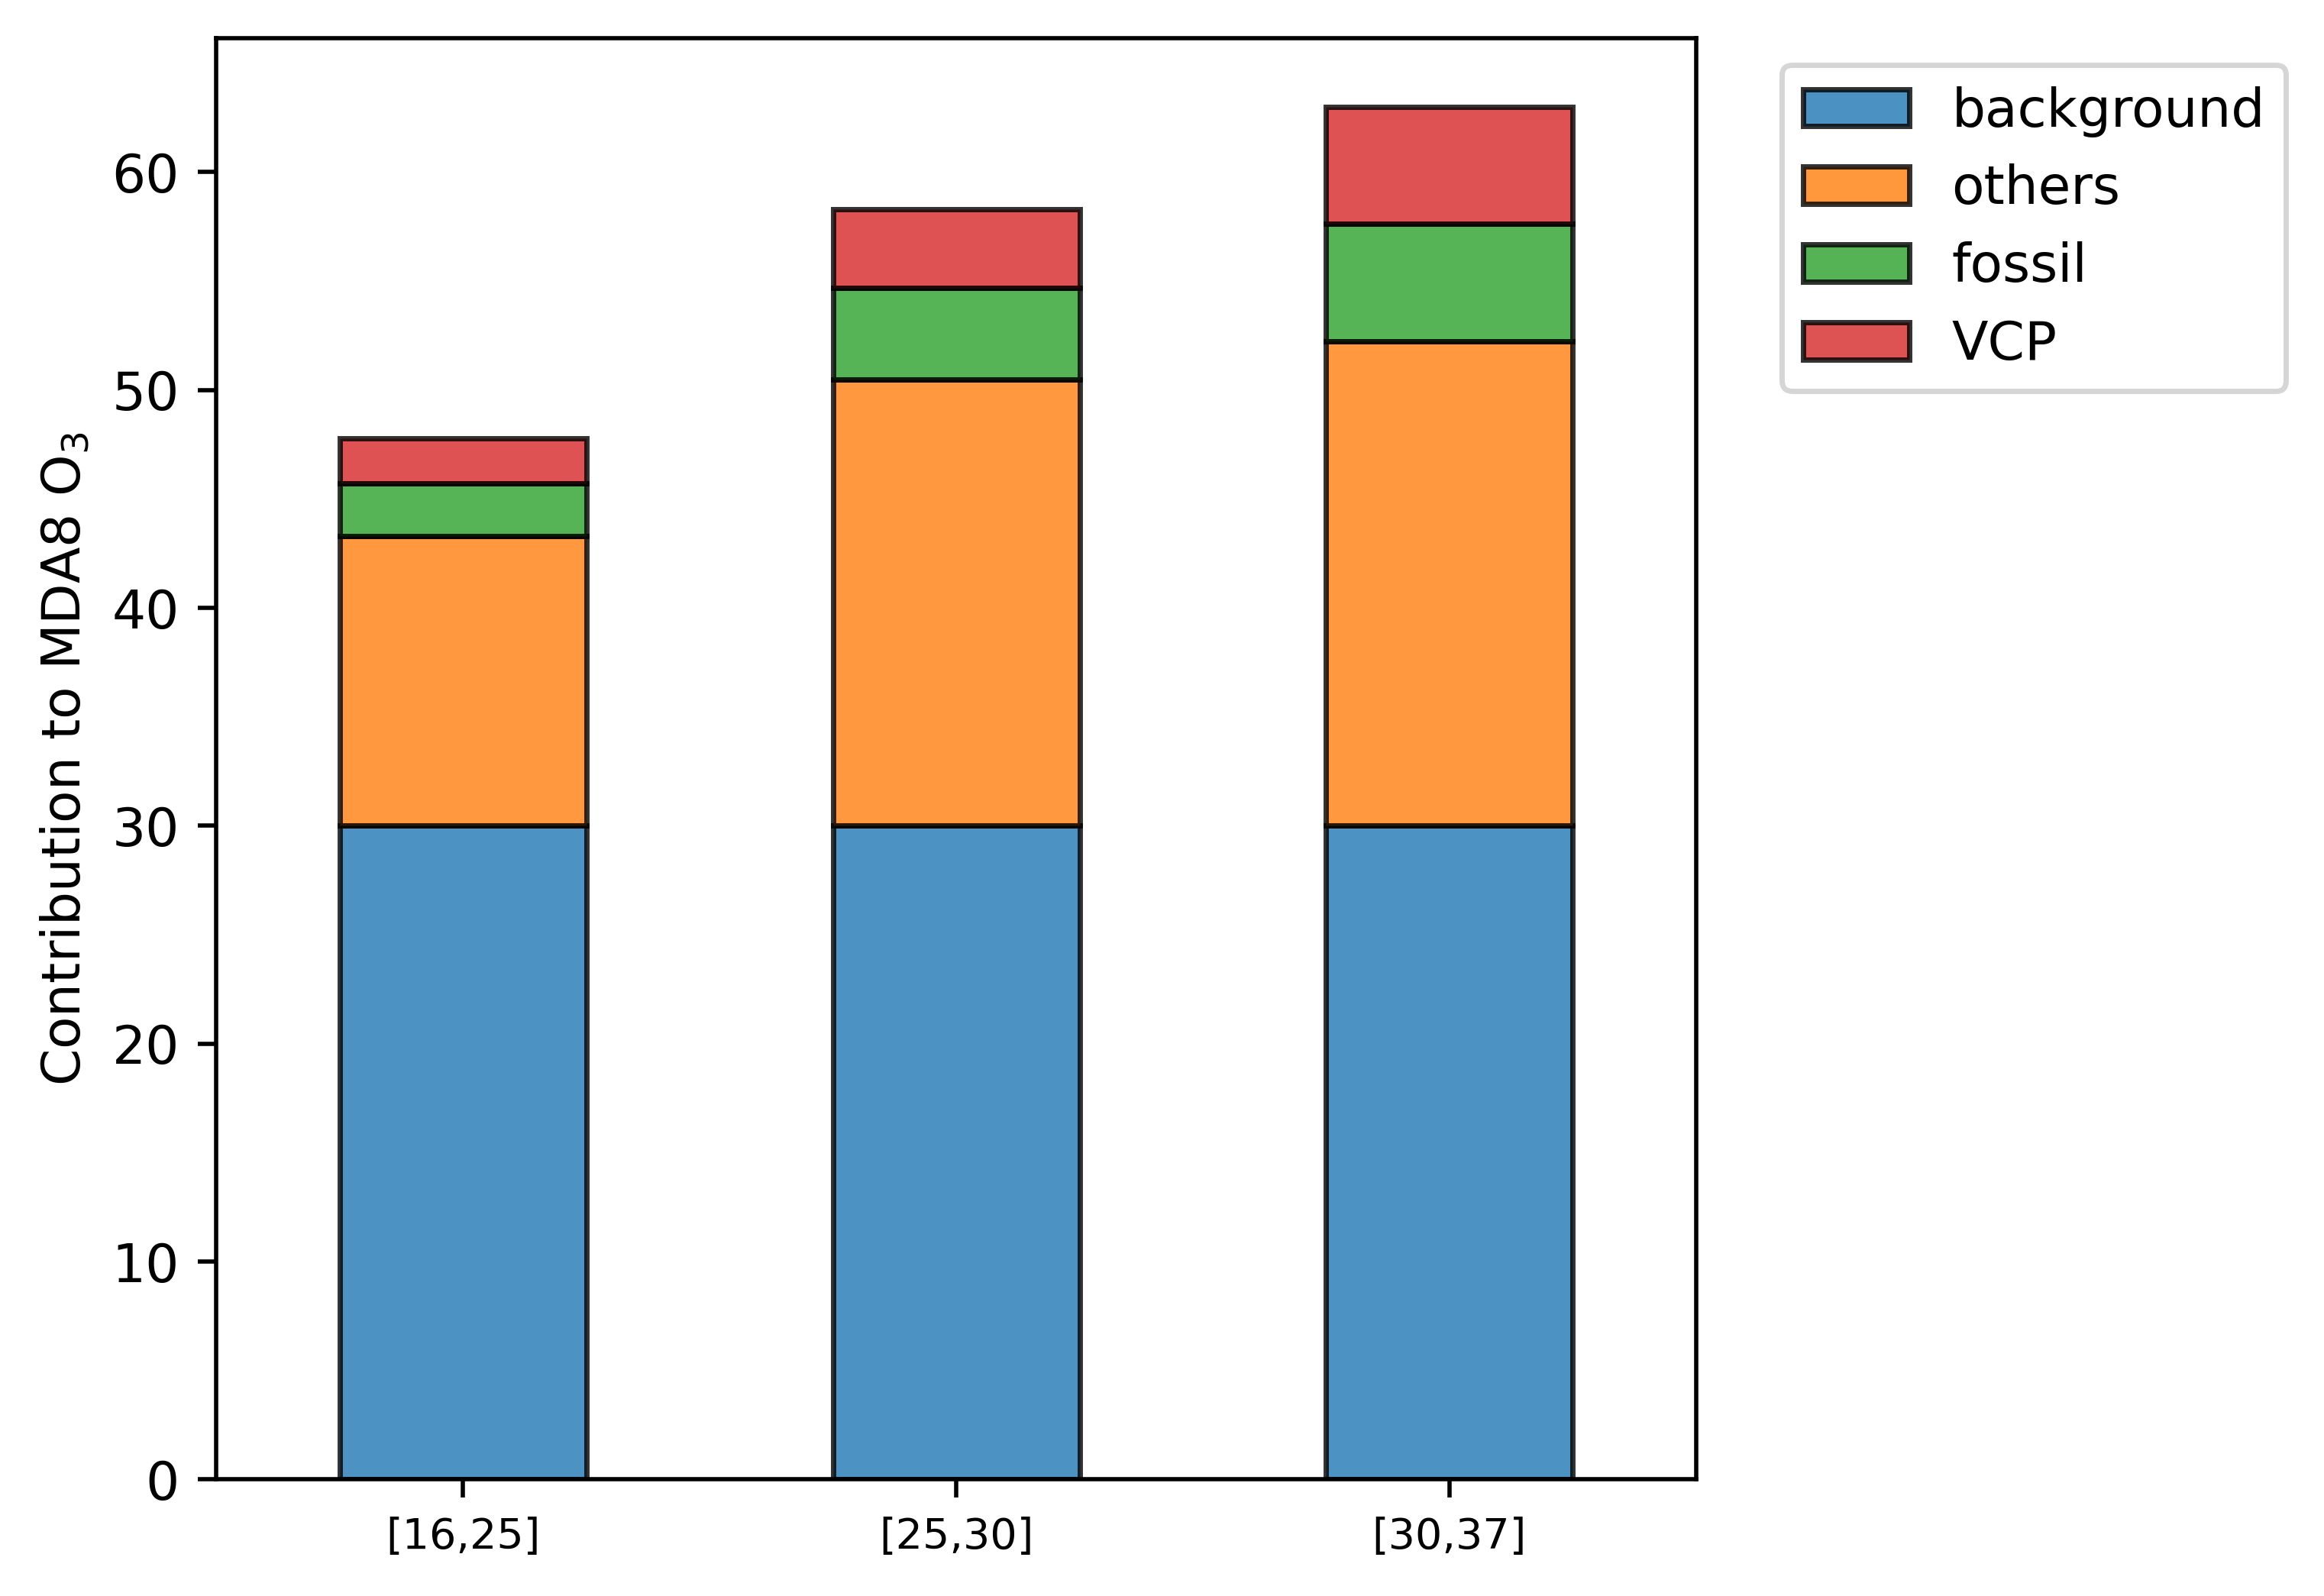

In [26]:
fig, axs = plt.subplots(1,1,figsize=(5,5),dpi=500)
boxcolors = ['white','tab:gray','tab:blue','tab:red']
o3_daily_temp.loc[:,['background','others','fossil','VCP']].plot(kind='bar', stacked=True, ax=axs, edgecolor='black',alpha=0.8, rot=0)
axs.set_xticks(o3_daily_temp_ratio.index,['[16,25]','[25,30]','[30,37]'], fontsize=8,rotation=0)
#axs.set_xticks(o3_daily_temp_ratio.index,['[21,27]','[27,30]','[30,35]'], fontsize=8,rotation=0)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.ylim([0,1])
plt.ylabel('Contribution to MDA8 O$_3$')
plt.xlabel('')



Text(0.5, 0, '')

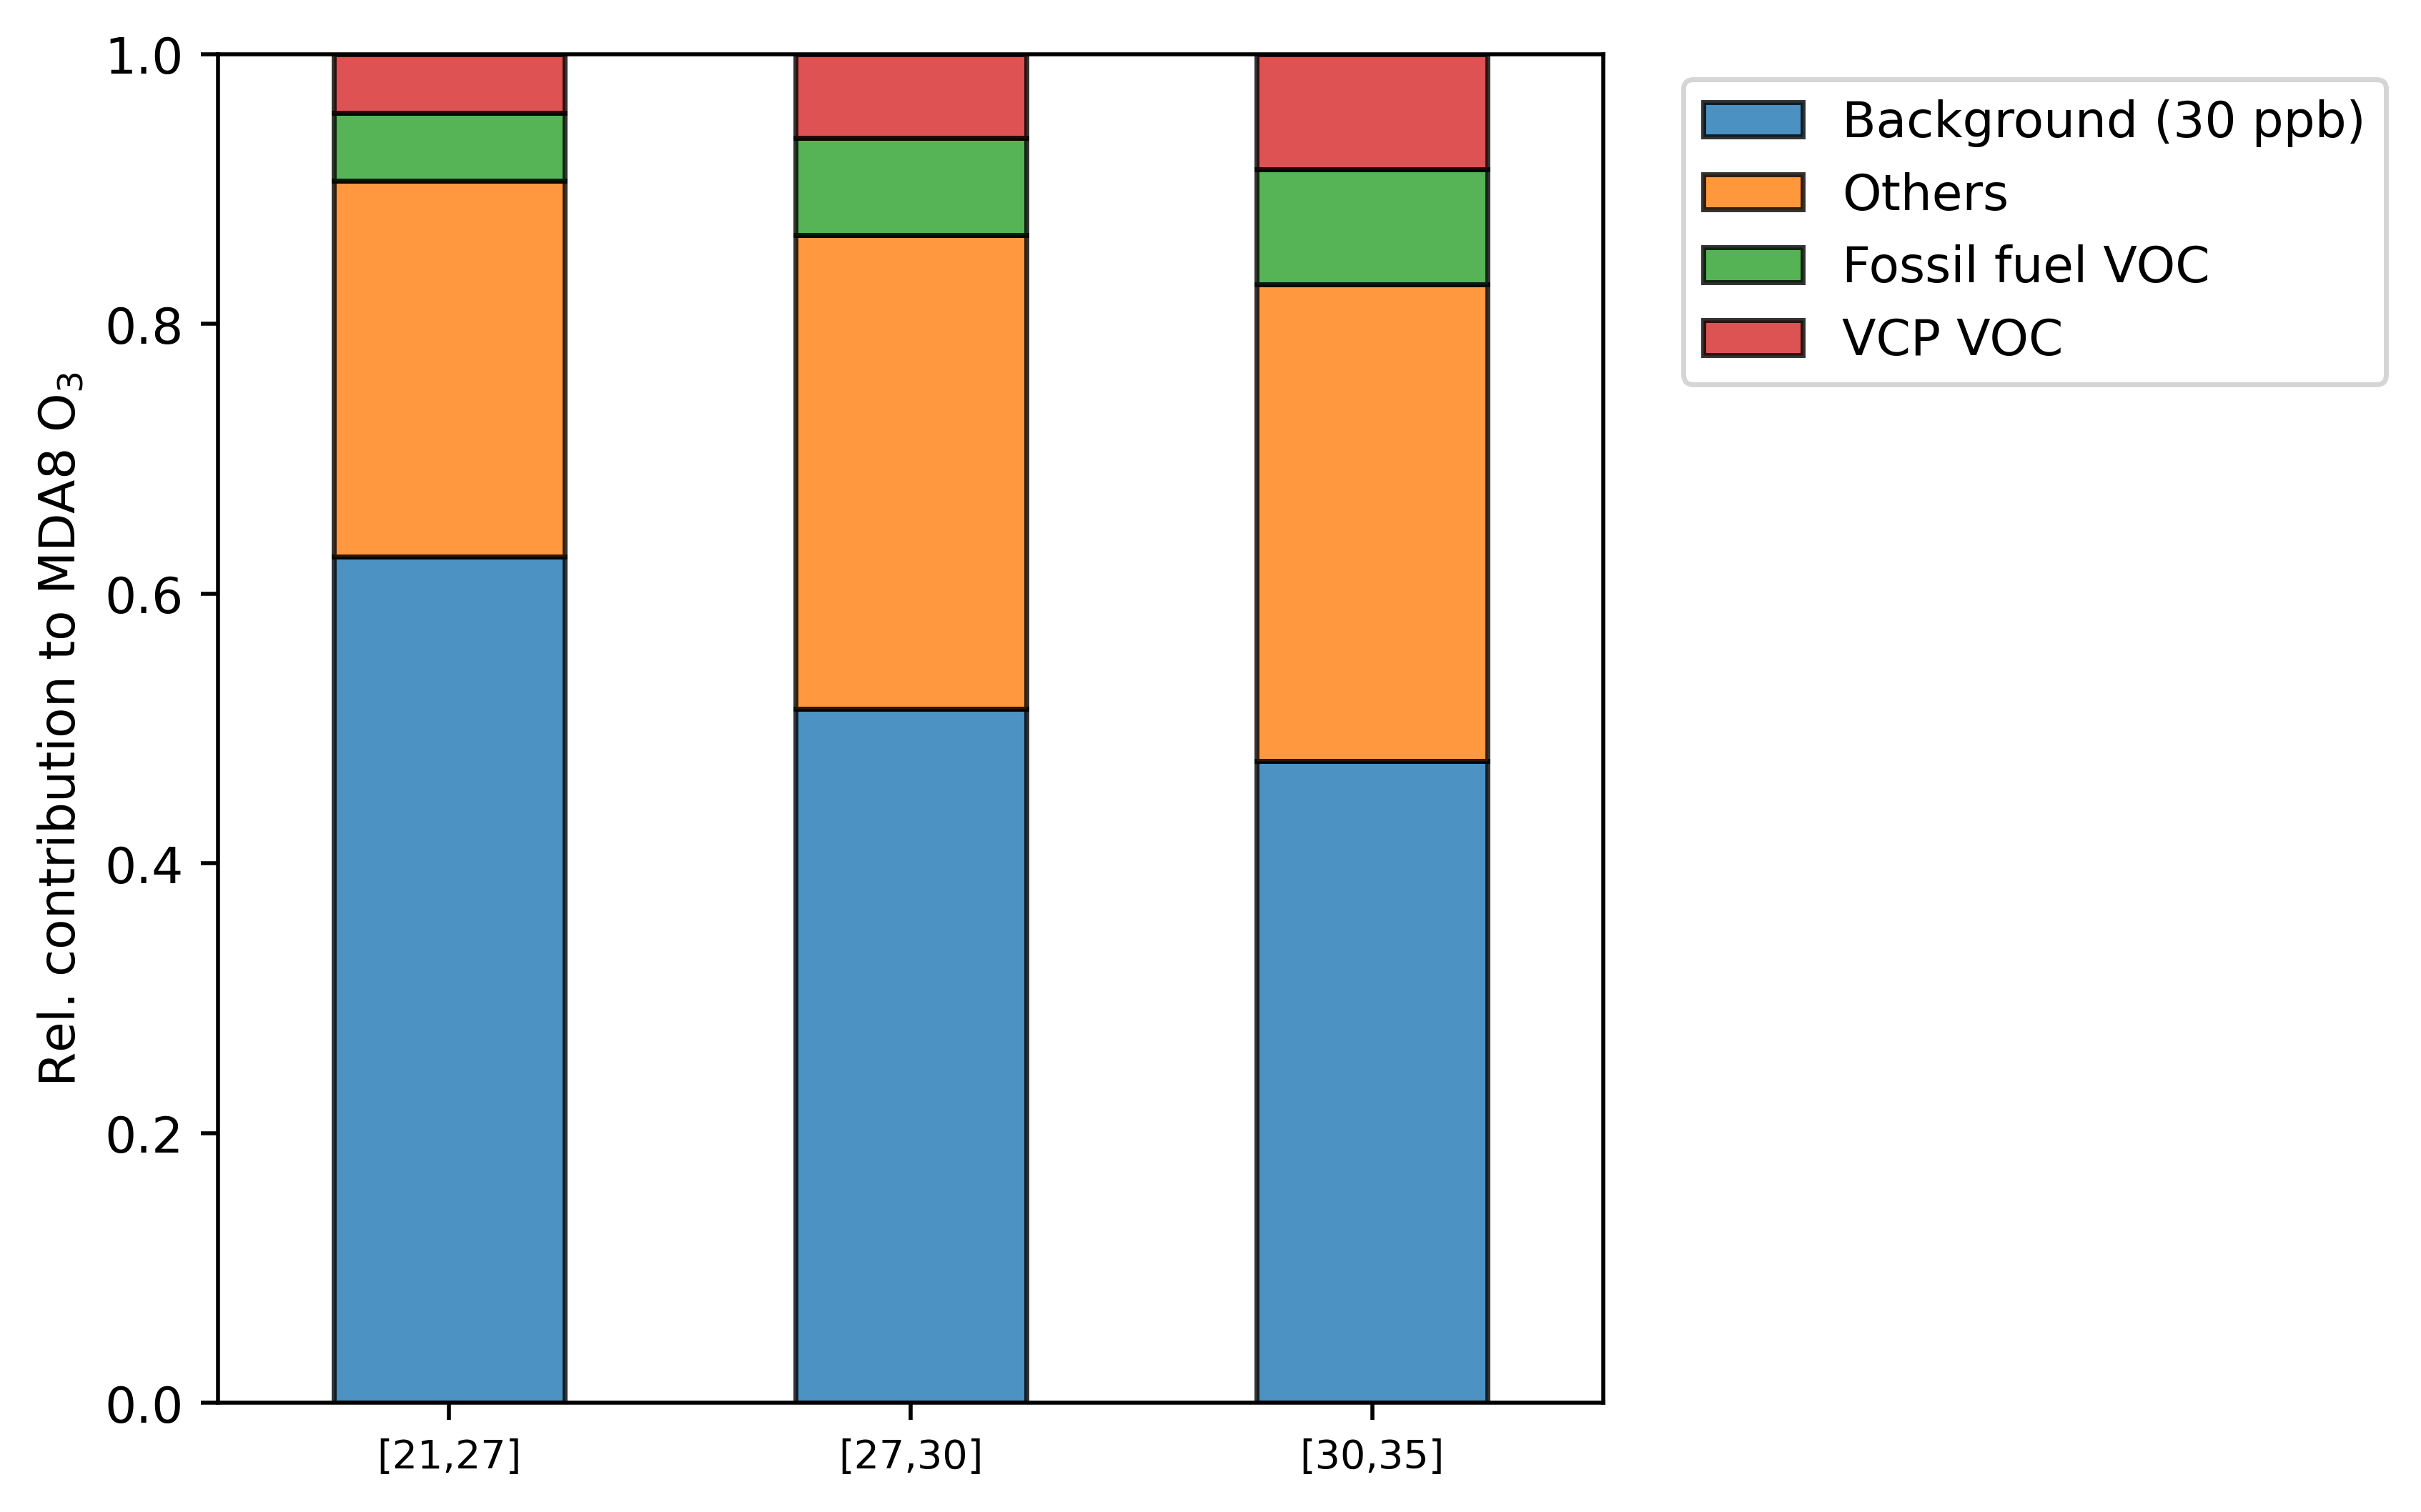

In [27]:
fig, axs = plt.subplots(1,1,figsize=(5,5),dpi=500)
boxcolors = ['white','tab:gray','tab:blue','tab:red']
o3_daily_temp_ratio.plot(kind='bar', stacked=True, ax=axs, edgecolor='black',alpha=0.8, rot=0)
#axs.set_xticks(o3_daily_temp_ratio.index,['[16,25]','[25,30]','[30,37]'], fontsize=8,rotation=0)
axs.set_xticks(o3_daily_temp_ratio.index,['[21,27]','[27,30]','[30,35]'], fontsize=8,rotation=0)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylim([0,1])
plt.ylabel('Rel. contribution to MDA8 O$_3$')
plt.xlabel('')

Text(0.5, 0, '')

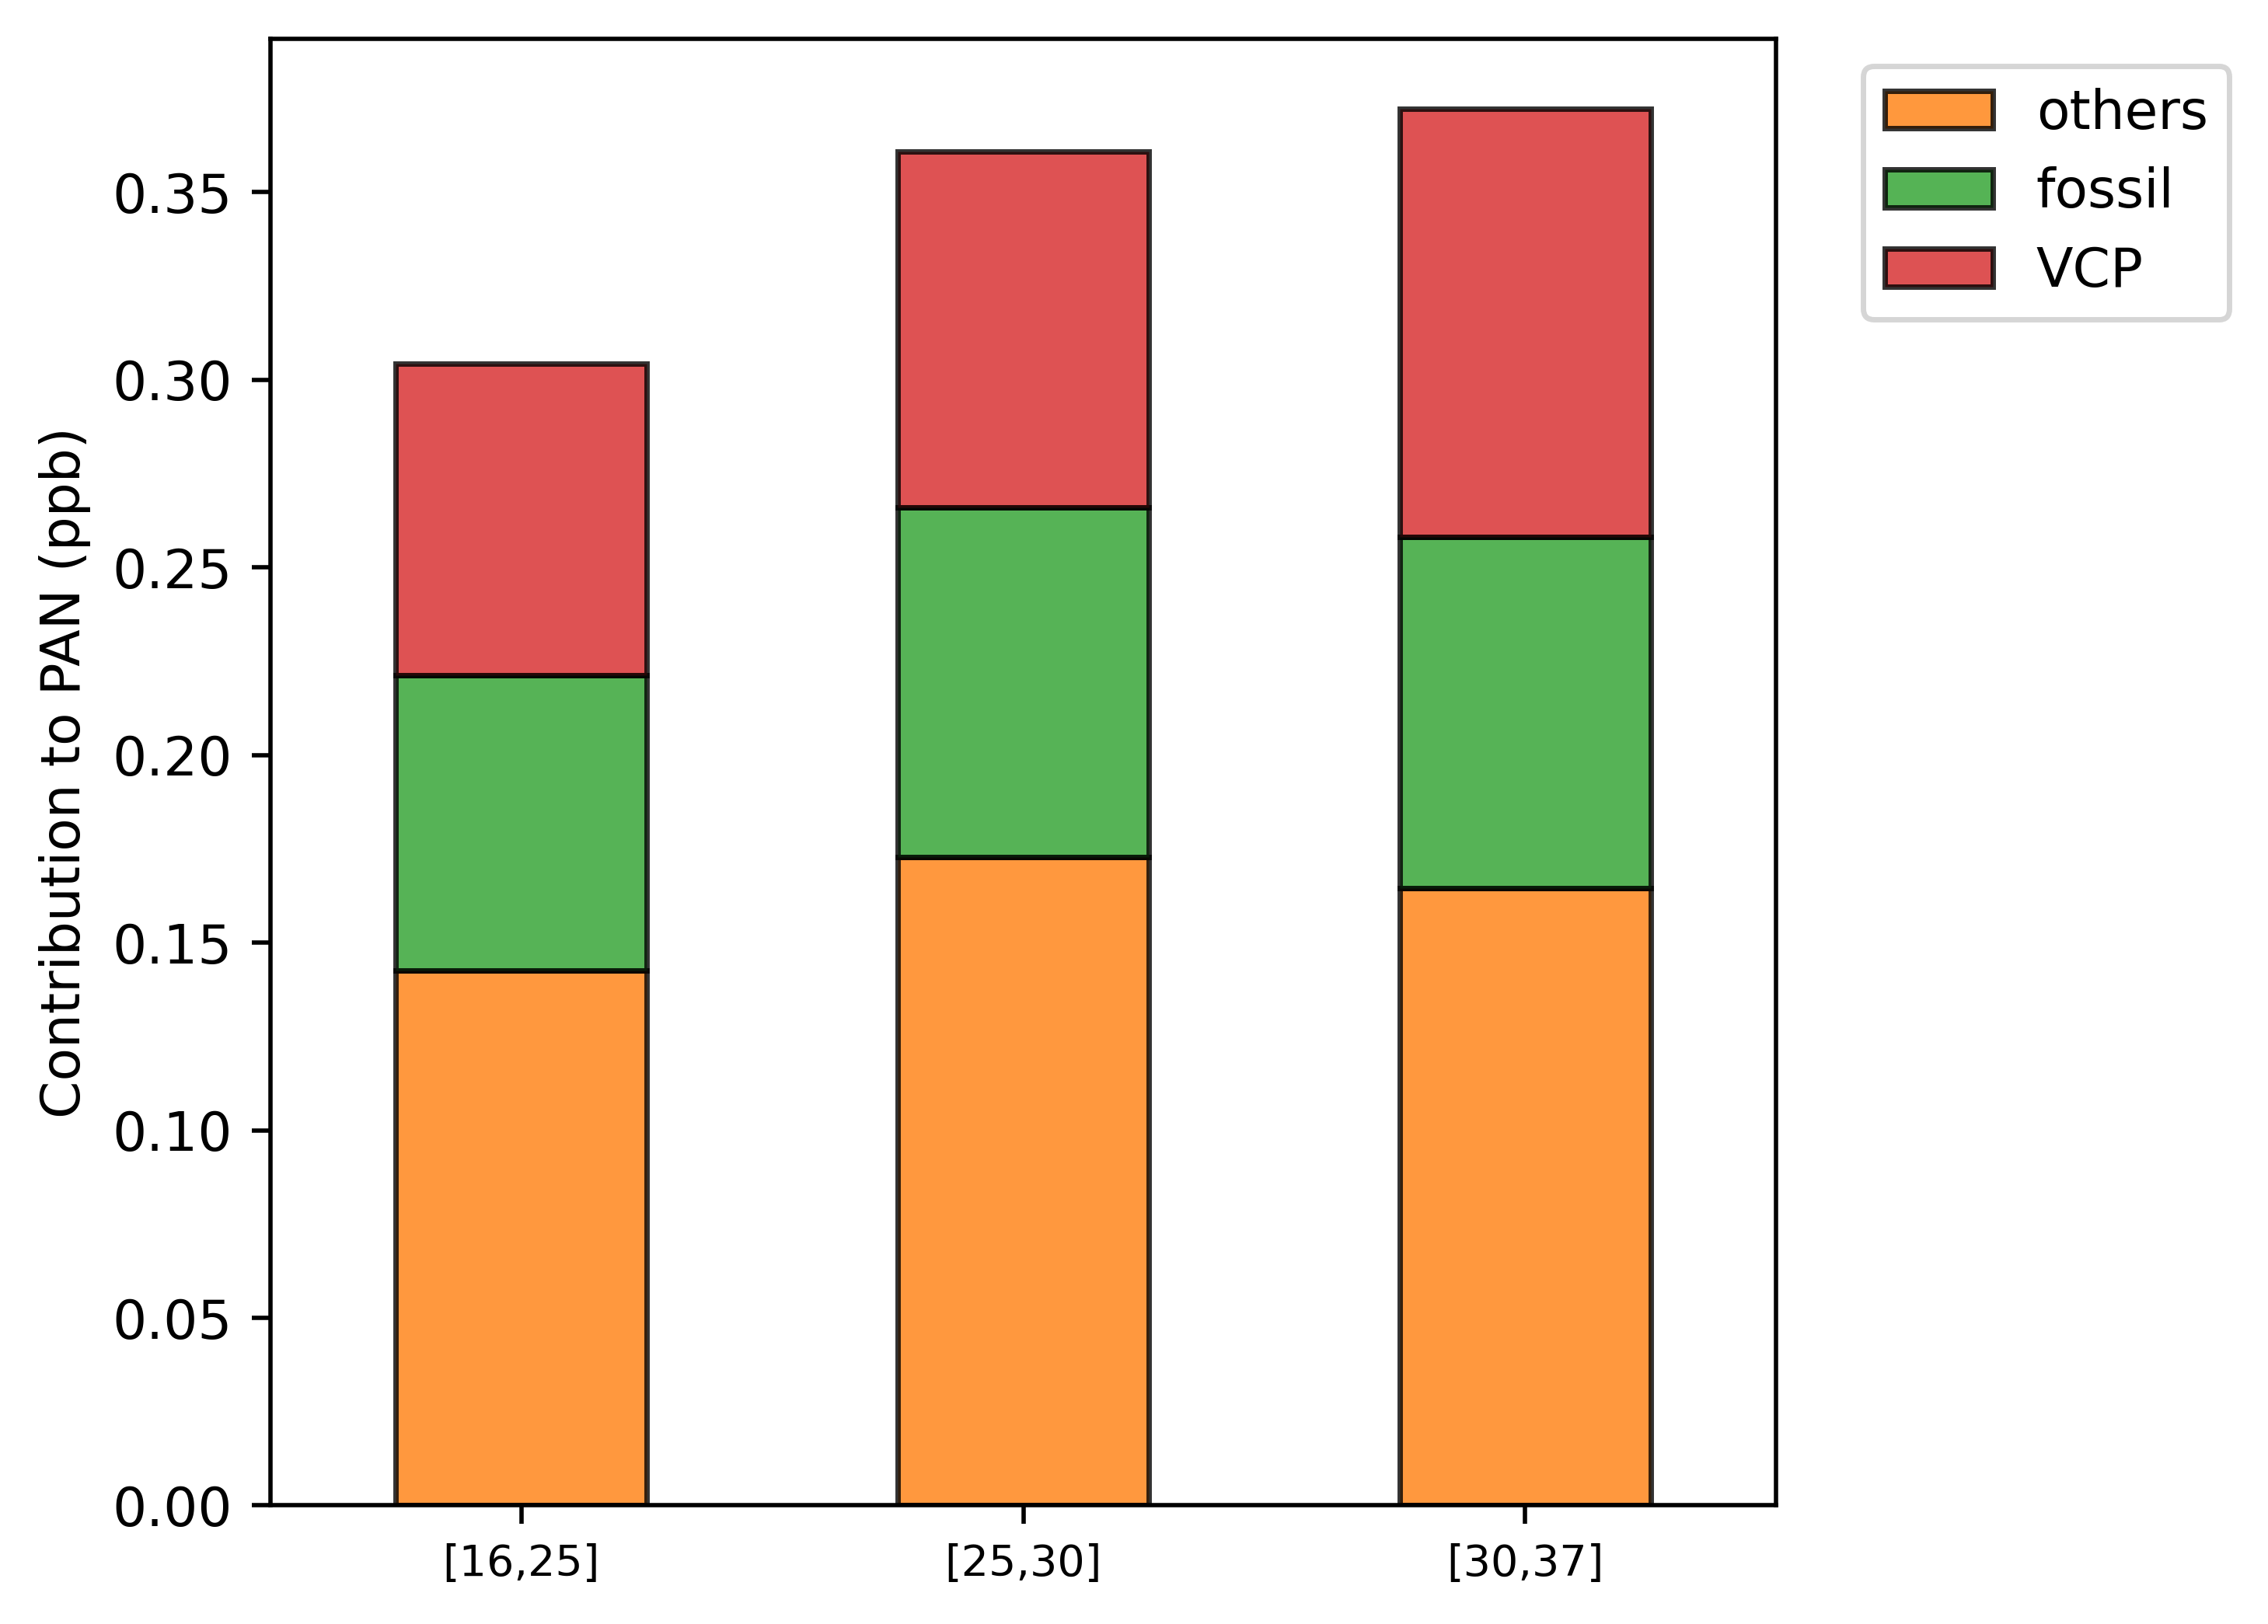

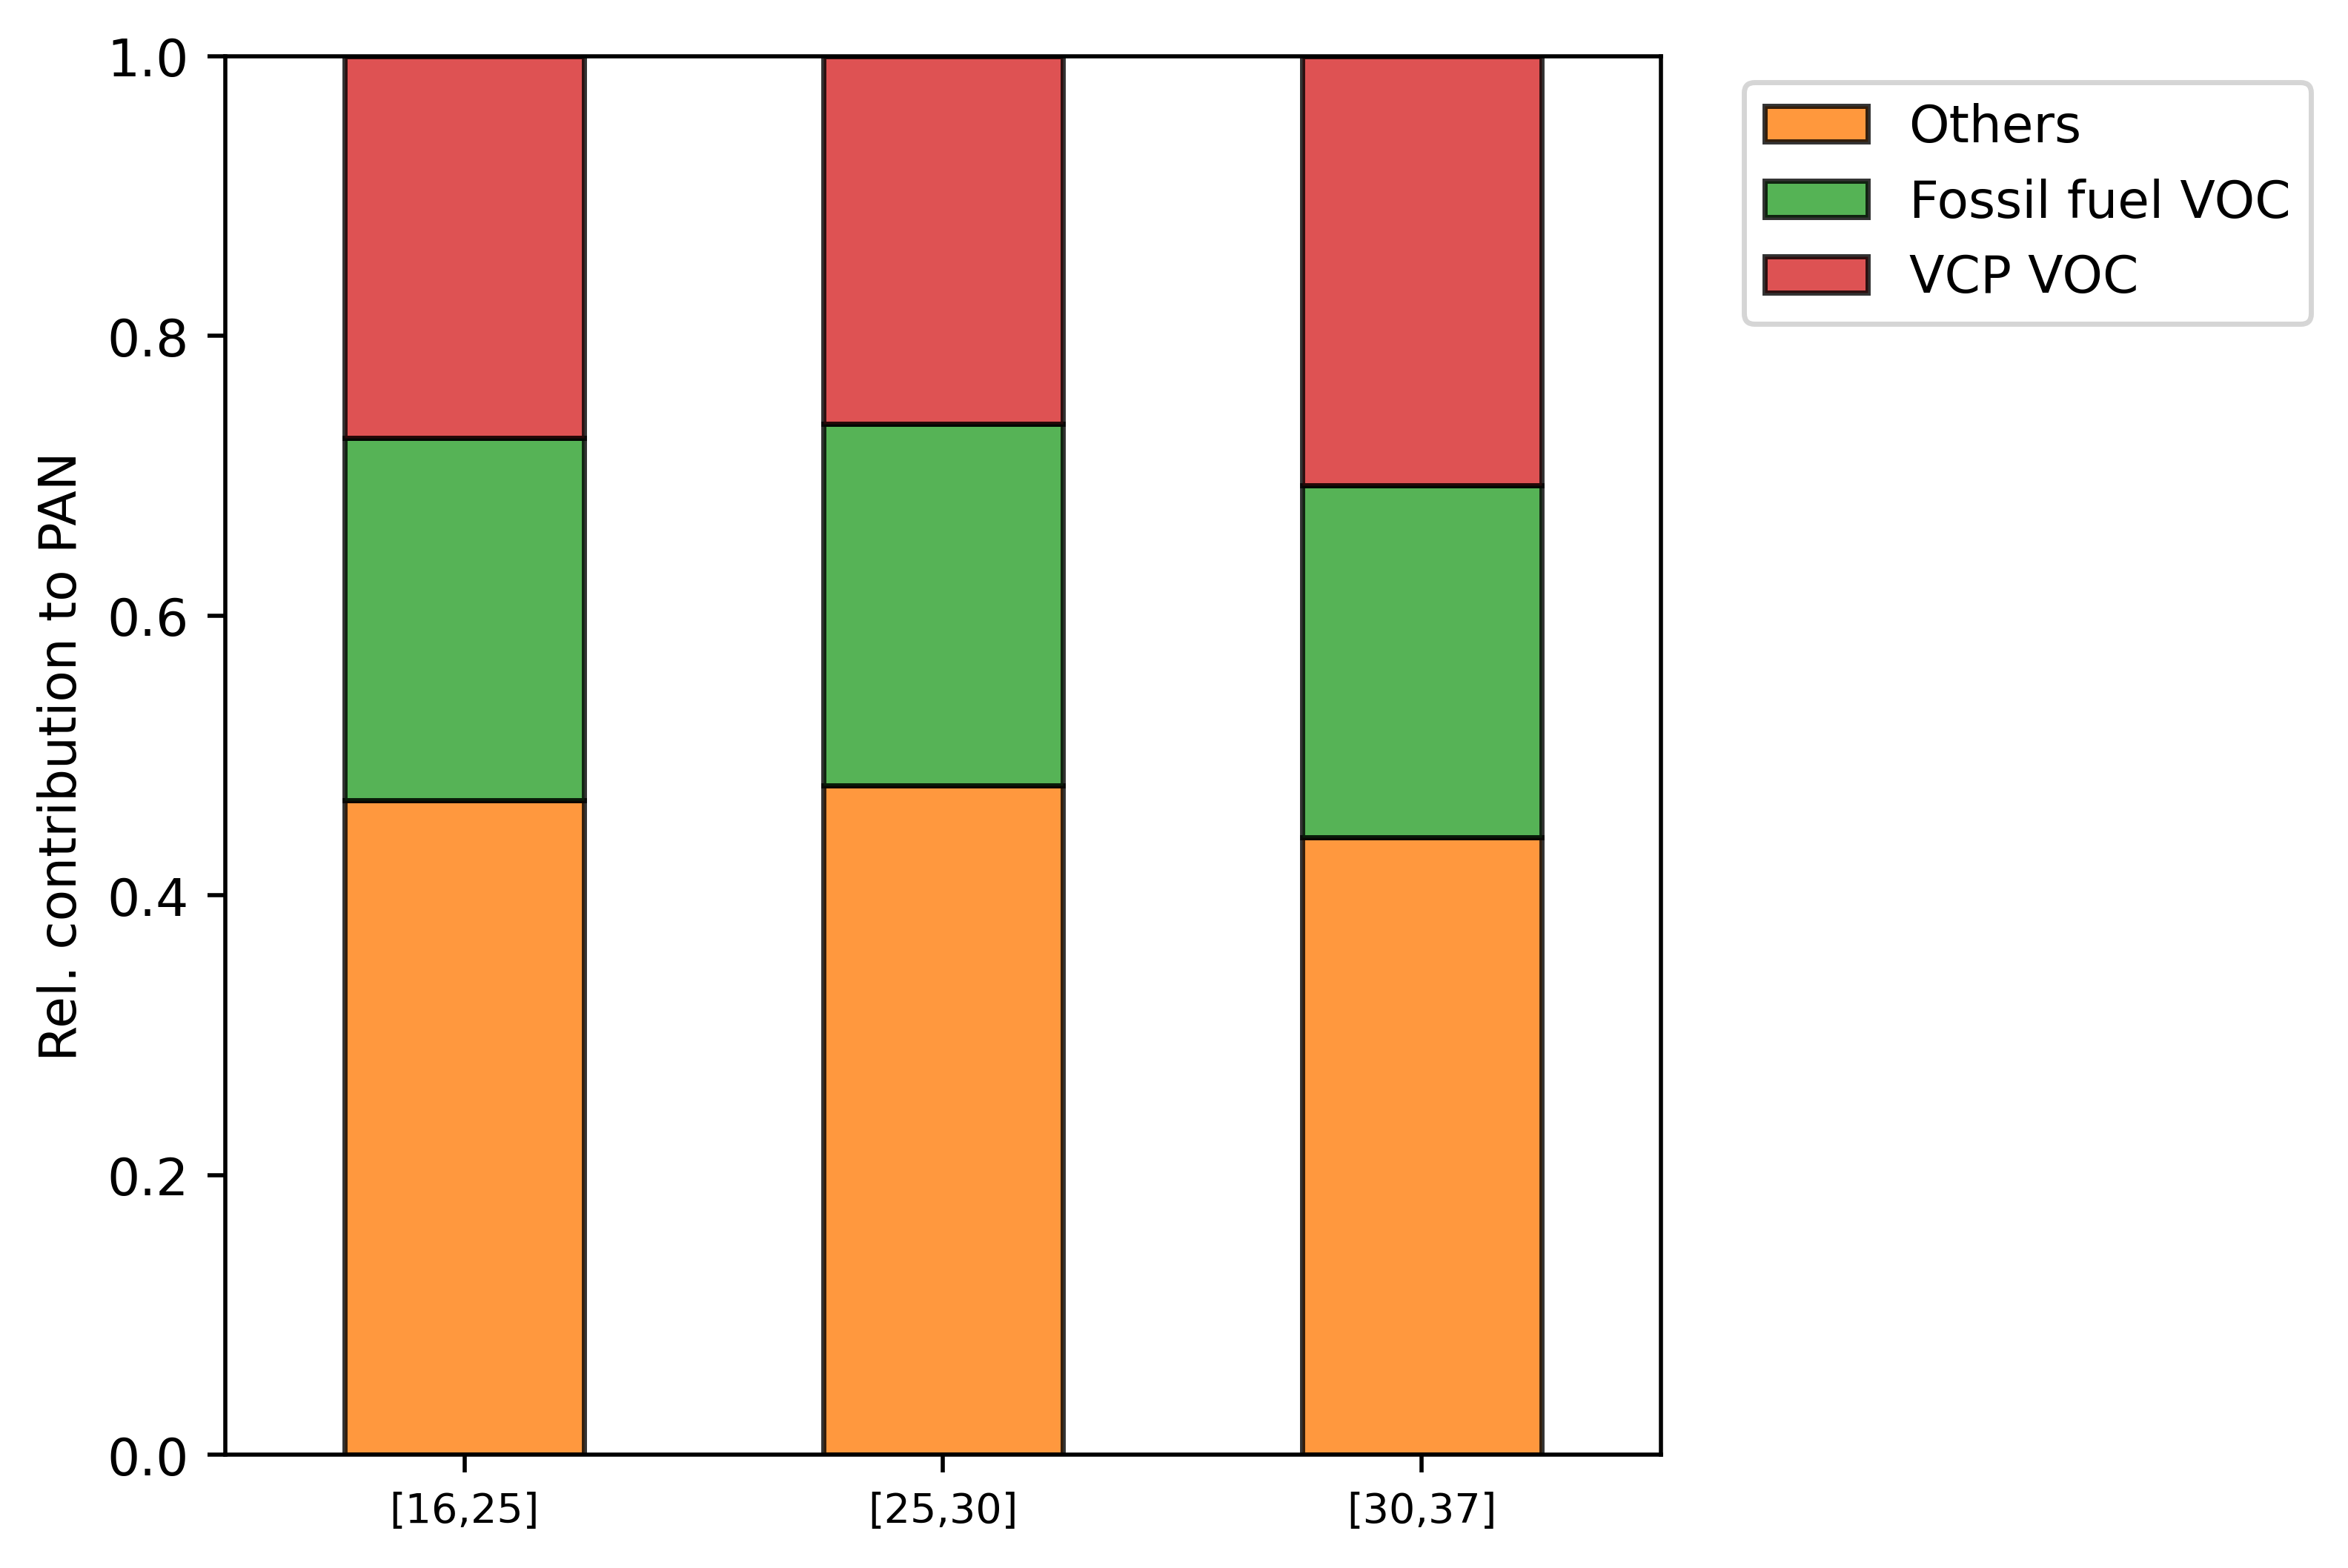

In [39]:
o3_daily = pd.DataFrame()

for i_day, this_day in enumerate(recap_days):
    gdfs = gdfs_tot[i_day]
    o3_daily.loc[i_day,'VCP'] = gdfs[1]['pan'].mean() - gdfs[2]['pan'].mean()
    o3_daily.loc[i_day,'fossil'] = gdfs[2]['pan'].mean() - gdfs[0]['pan'] .mean()
    o3_daily.loc[i_day,'others'] = gdfs[0]['pan'].mean()
    o3_daily.loc[i_day,'tot'] = gdfs[1]['pan'].mean()
    o3_daily.loc[i_day,'temp_bin_index'] = temp_bin_index[i_day]
o3_daily_temp = o3_daily.groupby('temp_bin_index').mean()
o3_daily_temp['VCP VOC'] = o3_daily_temp['VCP']/o3_daily_temp['tot']
o3_daily_temp['Fossil fuel VOC'] = o3_daily_temp['fossil']/o3_daily_temp['tot']
o3_daily_temp['Others'] = o3_daily_temp['others']/o3_daily_temp['tot']
o3_daily_temp_ratio = o3_daily_temp.loc[:,['Others','Fossil fuel VOC','VCP VOC']]

fig, axs = plt.subplots(1,1,figsize=(5,5),dpi=500)
boxcolors = ['tab:orange','tab:green','tab:red']
o3_daily_temp.loc[:,['others','fossil','VCP']].plot(kind='bar',color=boxcolors, stacked=True, ax=axs, edgecolor='black',alpha=0.8, rot=0)
axs.set_xticks(o3_daily_temp.index,['[16,25]','[25,30]','[30,37]'], fontsize=8,rotation=0)
#axs.set_xticks(o3_daily_temp_ratio.index,['[21,27]','[27,30]','[30,35]'], fontsize=8,rotation=0)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.ylim([0,1])
plt.ylabel('Contribution to PAN (ppb)')
plt.xlabel('')

fig, axs = plt.subplots(1,1,figsize=(5,5),dpi=500)
boxcolors = ['tab:orange','tab:green','tab:red']
o3_daily_temp_ratio.loc[:,['Others','Fossil fuel VOC','VCP VOC']].plot(kind='bar',color=boxcolors, stacked=True, ax=axs, edgecolor='black',alpha=0.8, rot=0)
axs.set_xticks(o3_daily_temp_ratio.index,['[16,25]','[25,30]','[30,37]'], fontsize=8,rotation=0)
#axs.set_xticks(o3_daily_temp_ratio.index,['[21,27]','[27,30]','[30,35]'], fontsize=8,rotation=0)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylim([0,1])
plt.ylabel('Rel. contribution to PAN')
plt.xlabel('')

Text(0.5, 0, '')

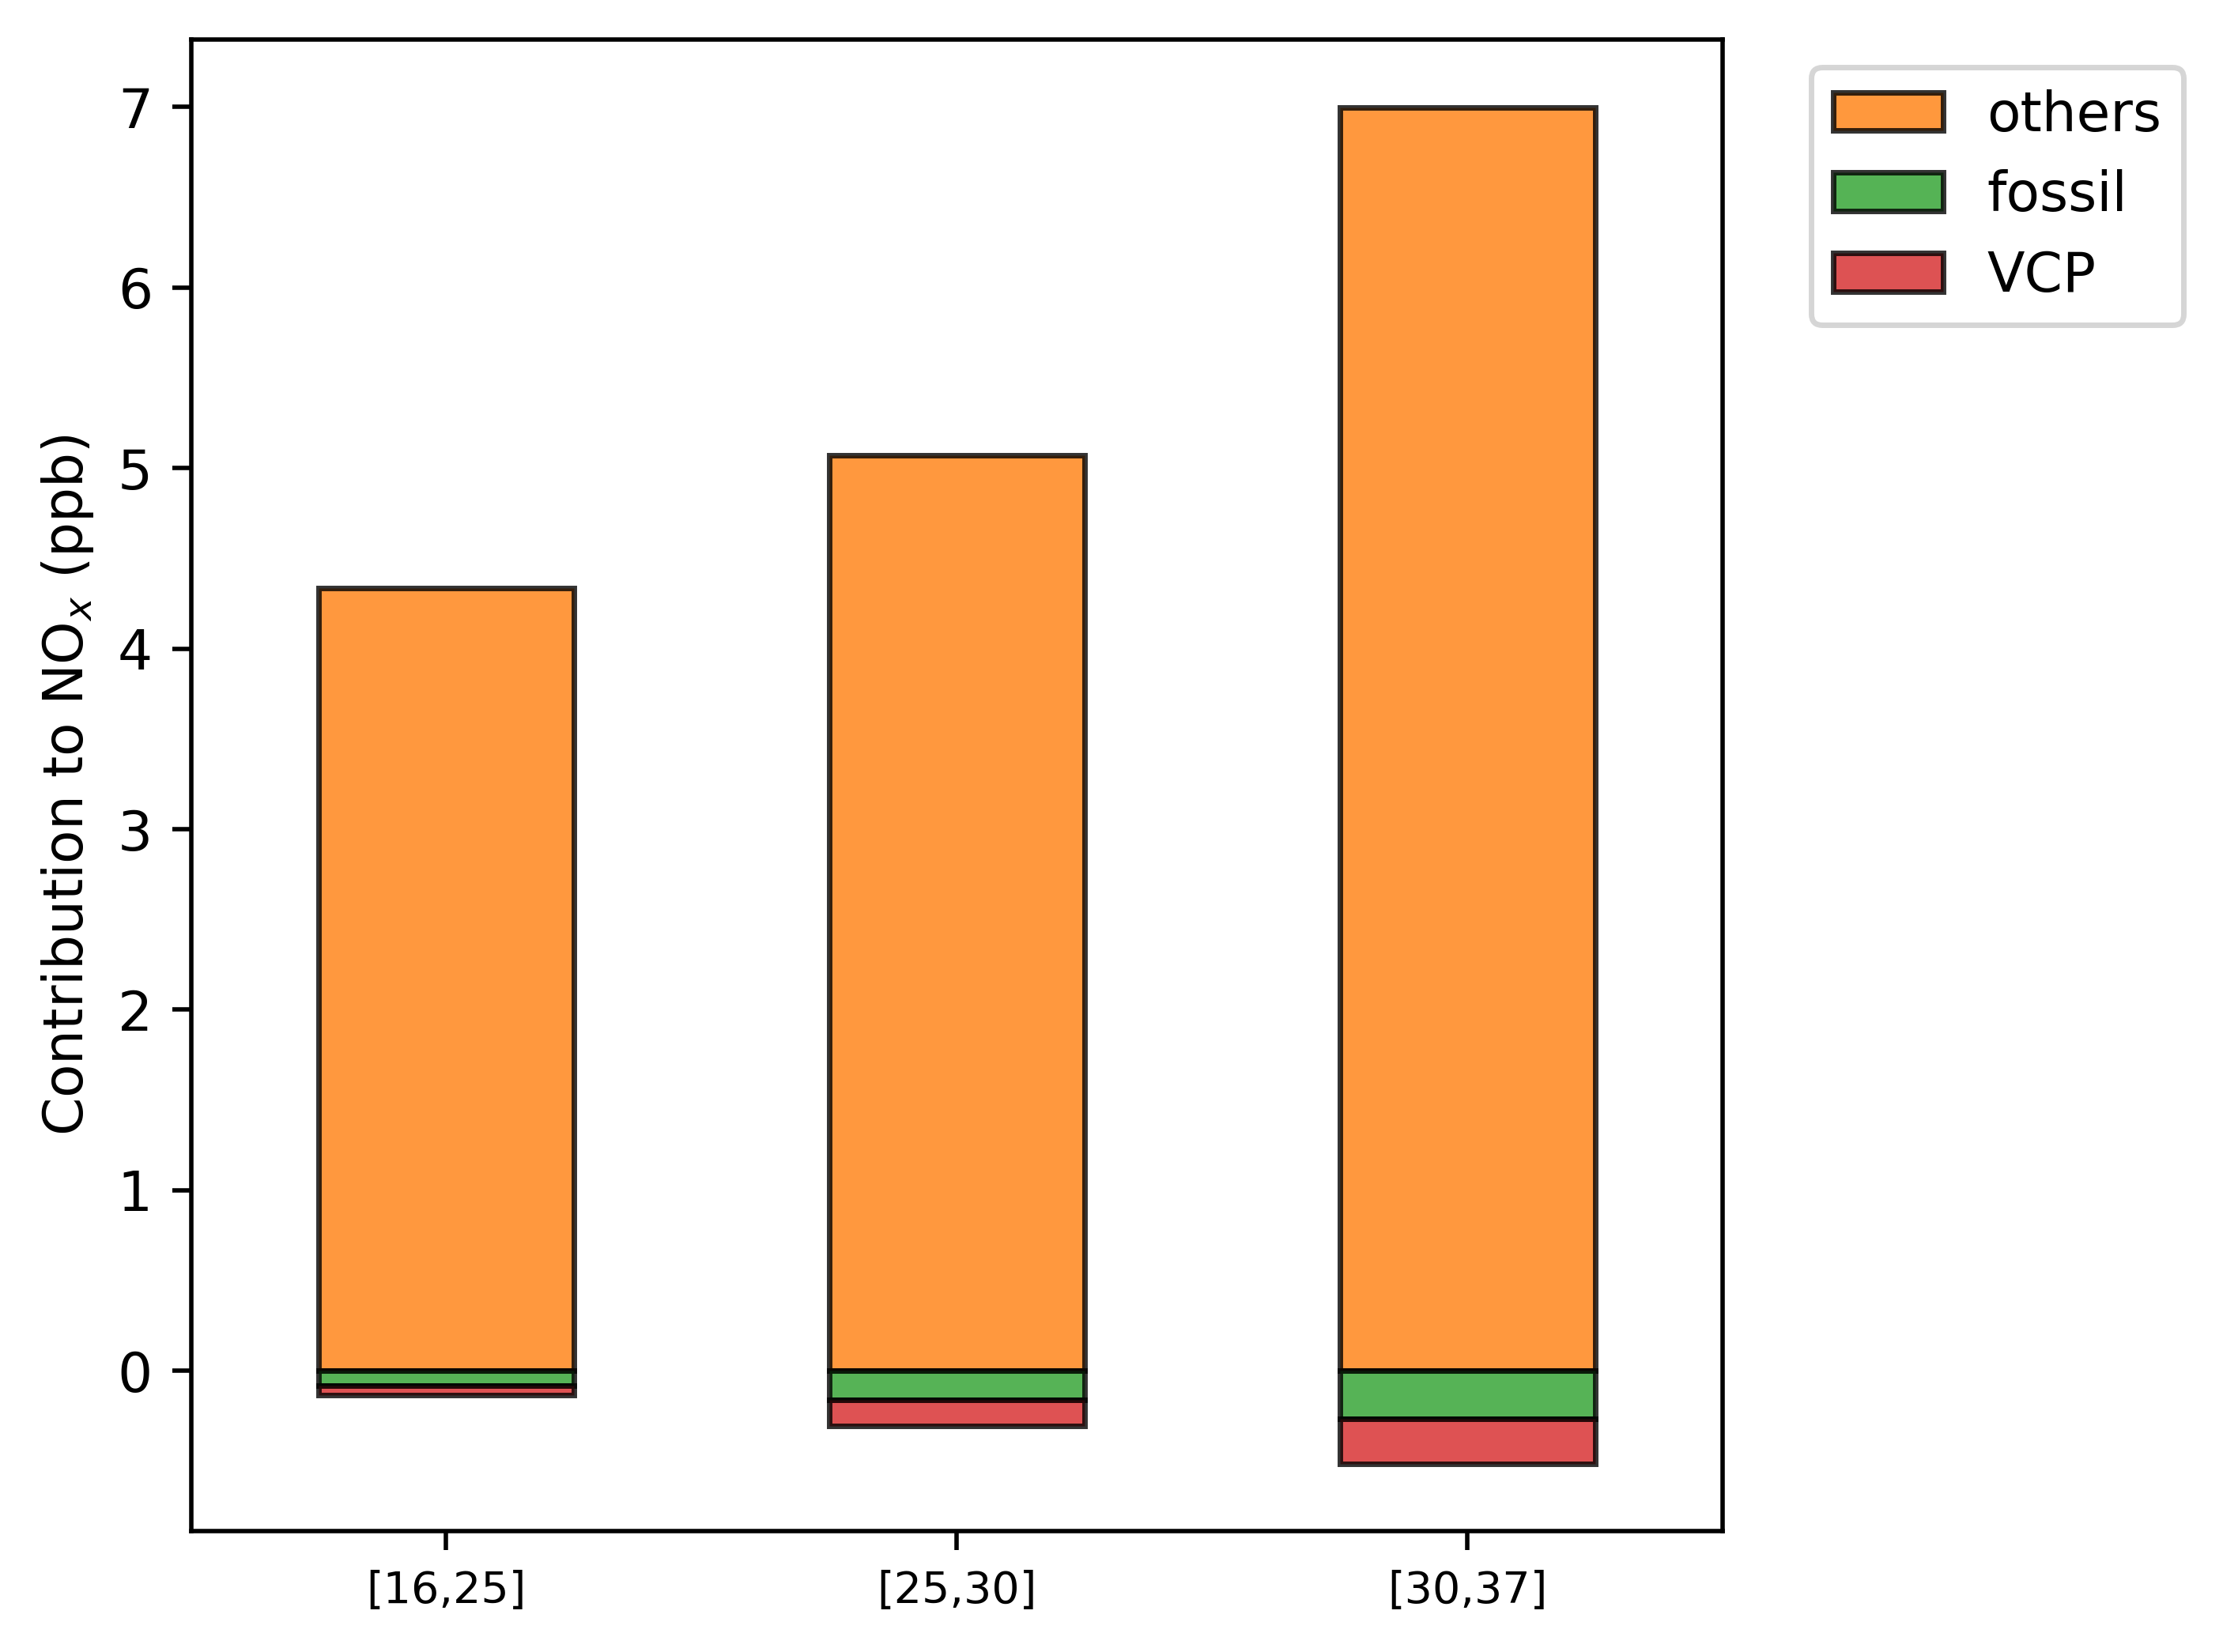

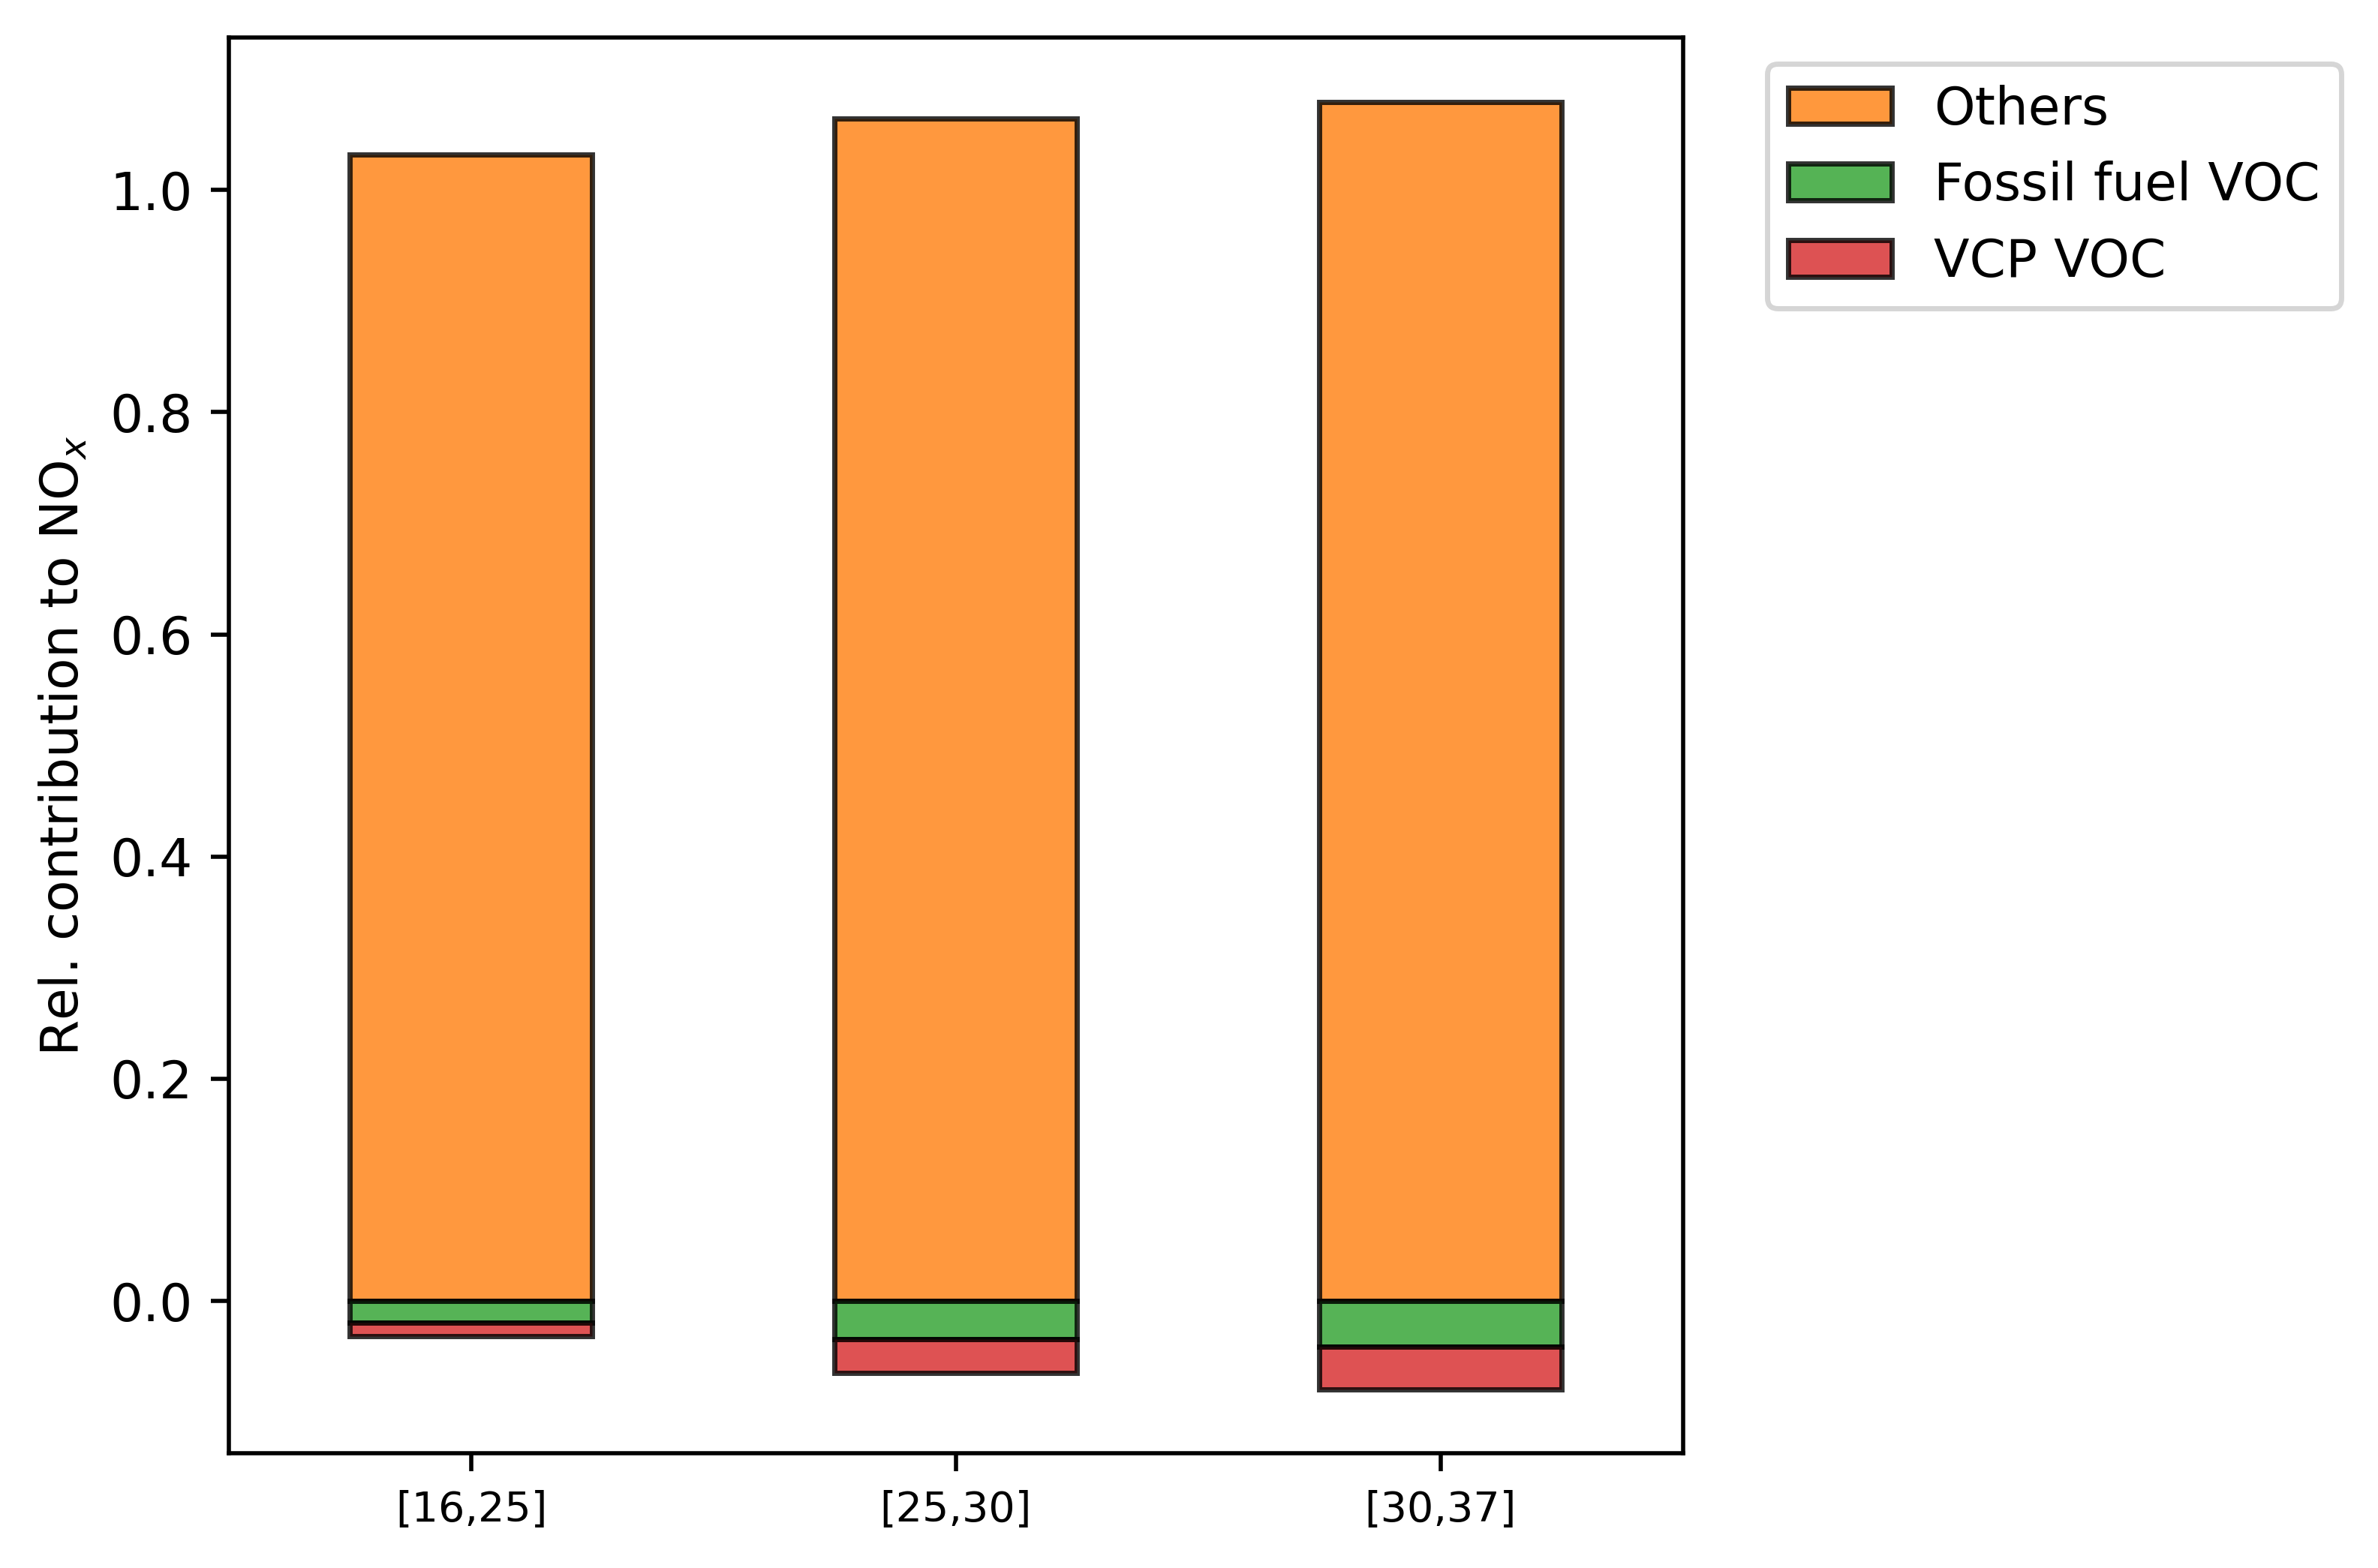

In [65]:
o3_daily = pd.DataFrame()

for i_day, this_day in enumerate(recap_days):
    gdfs = gdfs_tot[i_day]
    o3_daily.loc[i_day,'VCP'] = gdfs[1]['nox'].mean() - gdfs[2]['nox'].mean()
    o3_daily.loc[i_day,'fossil'] = gdfs[2]['nox'].mean() - gdfs[0]['nox'] .mean()
    o3_daily.loc[i_day,'others'] = gdfs[0]['nox'].mean()
    o3_daily.loc[i_day,'tot'] = gdfs[1]['nox'].mean()
    o3_daily.loc[i_day,'temp_bin_index'] = temp_bin_index[i_day]
    o3_daily.loc[i_day,'weekday_index'] = weekday_indx.values[i_day]
o3_daily = o3_daily[o3_daily['weekday_index']]
o3_daily_temp = o3_daily.groupby('temp_bin_index').mean()
o3_daily_temp['VCP VOC'] = o3_daily_temp['VCP']/o3_daily_temp['tot']
o3_daily_temp['Fossil fuel VOC'] = o3_daily_temp['fossil']/o3_daily_temp['tot']
o3_daily_temp['Others'] = o3_daily_temp['others']/o3_daily_temp['tot']
o3_daily_temp_ratio = o3_daily_temp.loc[:,['Others','Fossil fuel VOC','VCP VOC']]

fig, axs = plt.subplots(1,1,figsize=(5,5),dpi=500)
boxcolors = ['tab:orange','tab:green','tab:red']
o3_daily_temp.loc[:,['others','fossil','VCP']].plot(kind='bar',color=boxcolors, stacked=True, ax=axs, edgecolor='black',alpha=0.8, rot=0)
axs.set_xticks(o3_daily_temp.index,['[16,25]','[25,30]','[30,37]'], fontsize=8,rotation=0)
#axs.set_xticks(o3_daily_temp_ratio.index,['[21,27]','[27,30]','[30,35]'], fontsize=8,rotation=0)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.ylim([0,1])
plt.ylabel('Contribution to NO$_x$ (ppb)')
plt.xlabel('')

fig, axs = plt.subplots(1,1,figsize=(5,5),dpi=500)
boxcolors = ['tab:orange','tab:green','tab:red']
o3_daily_temp_ratio.loc[:,['Others','Fossil fuel VOC','VCP VOC']].plot(kind='bar',color=boxcolors, stacked=True, ax=axs, edgecolor='black',alpha=0.8, rot=0)
axs.set_xticks(o3_daily_temp_ratio.index,['[16,25]','[25,30]','[30,37]'], fontsize=8,rotation=0)
#axs.set_xticks(o3_daily_temp_ratio.index,['[21,27]','[27,30]','[30,35]'], fontsize=8,rotation=0)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.ylim([0,1])
plt.ylabel('Rel. contribution to NO$_x$')
plt.xlabel('')